Pixel size: 0.640221 micron/pixel (from XResolution)


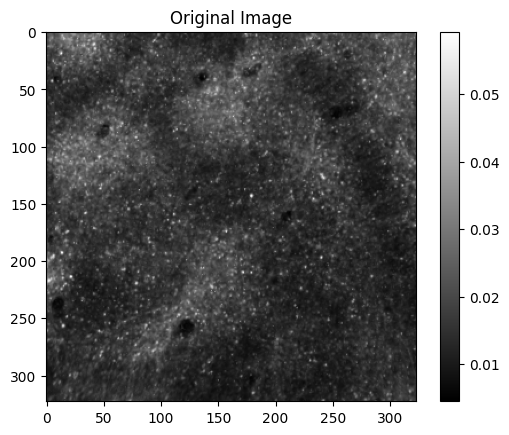

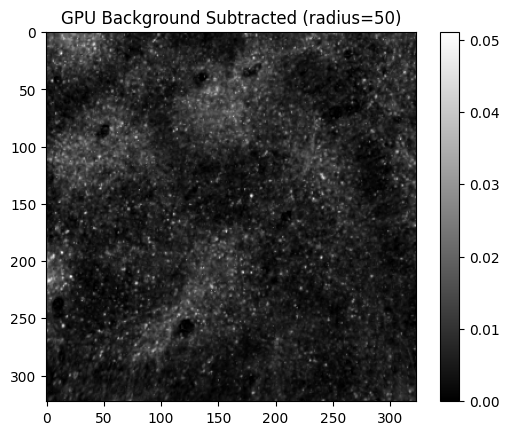

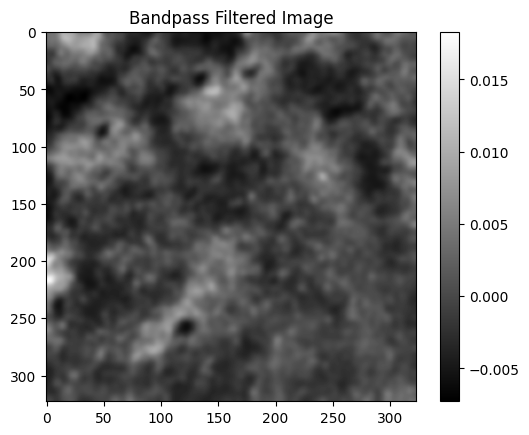

Padded size: 512


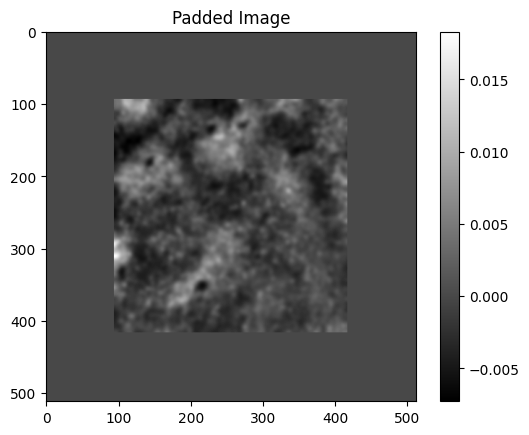

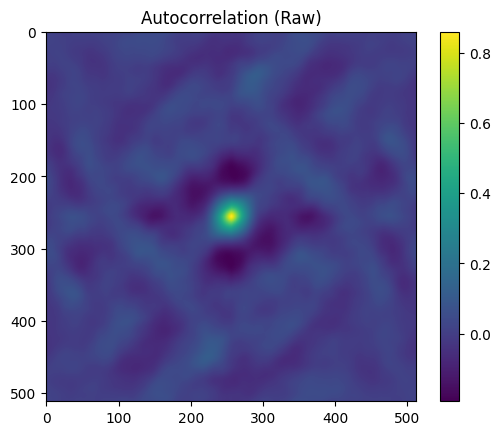

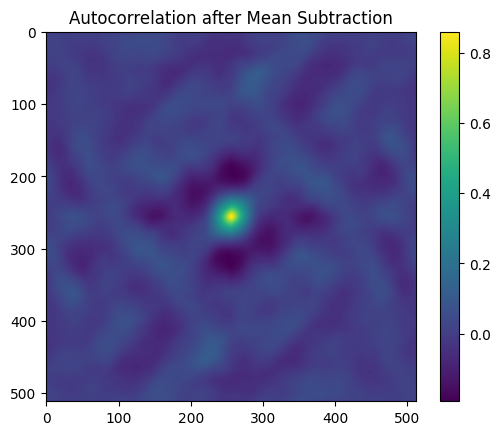

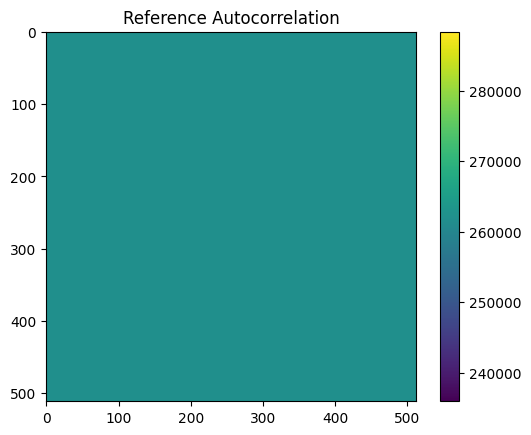

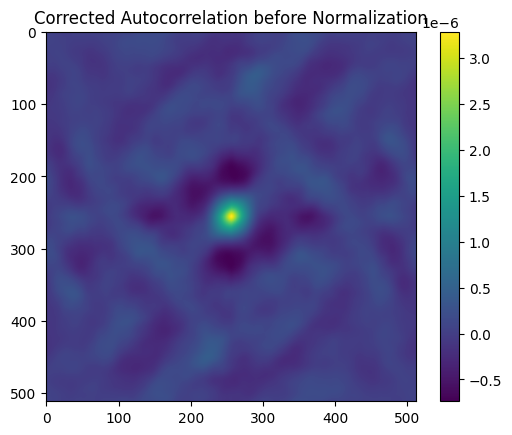

Normalization value (center): 3.284502932211771e-06


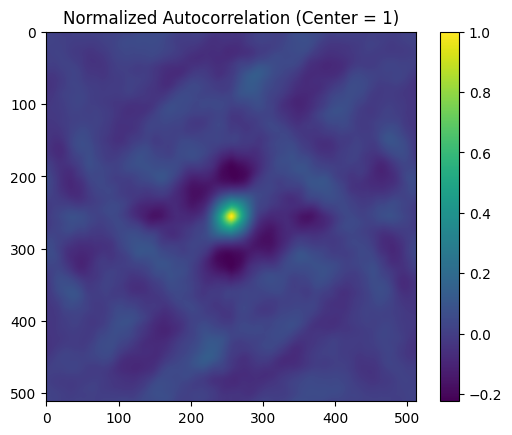

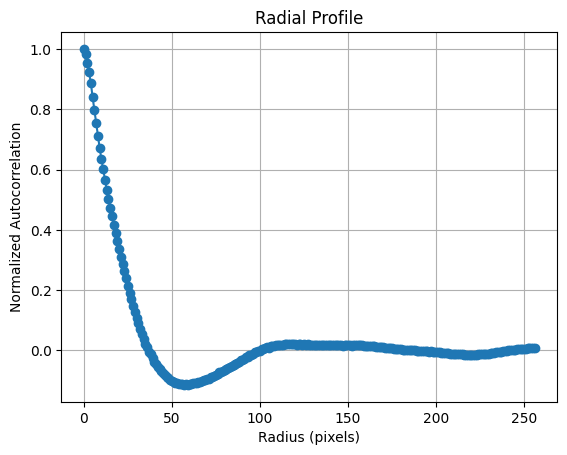

50% width (half maximum) at: 15.00 pixels, or 9.60 microns
First negative peak amplitude: -0.11


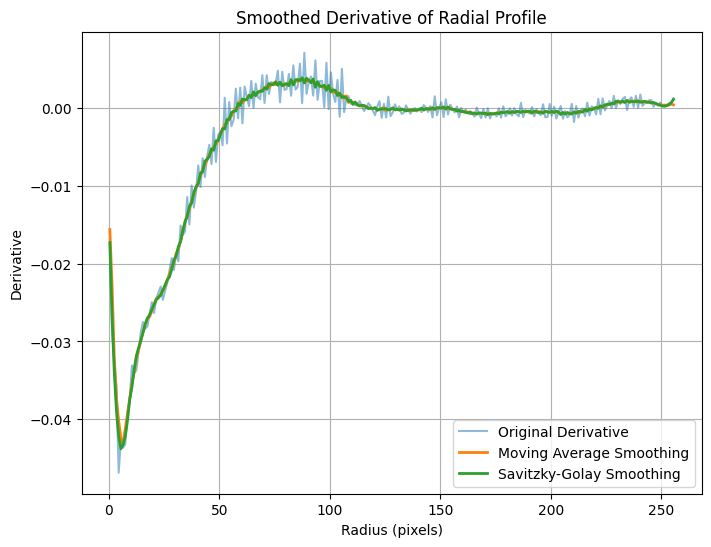

Distance of second positive peak: 117.00 pixels, or 74.91 microns


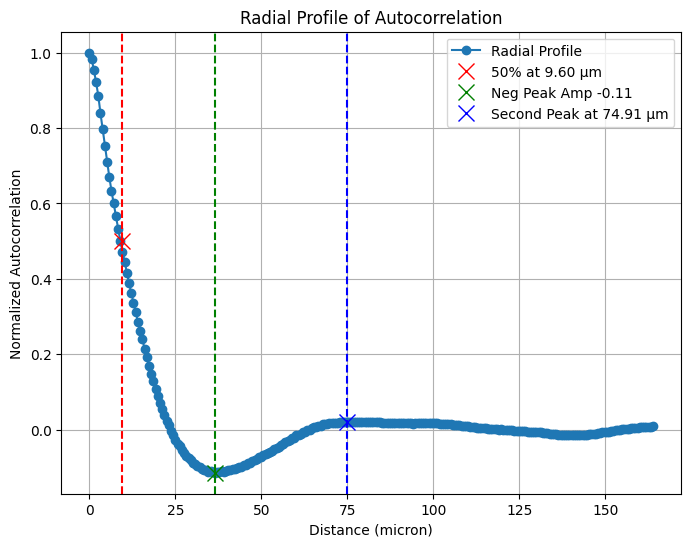

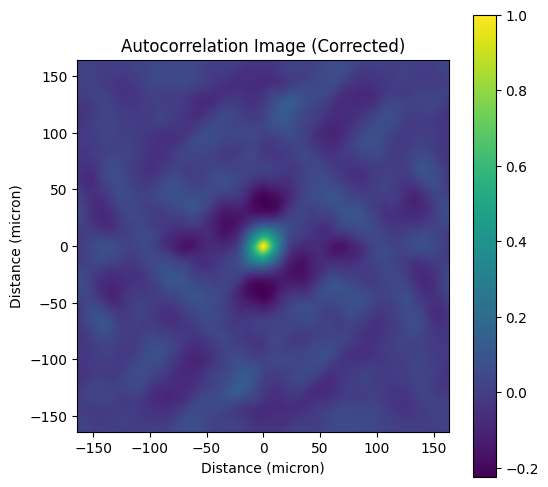

CPU times: user 4.47 s, sys: 2.84 s, total: 7.3 s
Wall time: 3.38 s


In [14]:
%%time
## test imageでのradial profile確認
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from numpy.fft import fft2, ifft2, fftshift

# Import cuPy and its GPU-accelerated ndimage functions
import cupy as cp
import cupyx.scipy.ndimage as cndimage

def next_power_of_two(n):
    """Return the smallest power of 2 greater than or equal to n."""
    return 2**int(np.ceil(np.log2(n)))

def bandpass_filter(image, sigma_small=3, sigma_large=40):
    """
    Apply a bandpass filter using a difference of Gaussians.
    sigma_small and sigma_large roughly correspond to ImageJ's parameters.
    """
    g_small = gaussian_filter(image, sigma=sigma_small)
    g_large = gaussian_filter(image, sigma=sigma_large)
    filtered = g_small - g_large
    return filtered

def pad_image_with_mean(image, pad_size):
    """
    Pad an image to a square of size (pad_size, pad_size) with the constant value
    equal to the image mean.
    """
    h, w = image.shape
    padded = np.full((pad_size, pad_size), np.mean(image), dtype=image.dtype)
    offset_y = (pad_size - h) // 2
    offset_x = (pad_size - w) // 2
    padded[offset_y:offset_y+h, offset_x:offset_x+w] = image
    return padded, offset_x, offset_y

def compute_autocorrelation(image):
    """
    Compute the autocorrelation of an image using the FFT.
    The result is shifted so that the zero lag is at the center.
    """
    F = fft2(image)
    auto_corr = ifft2(np.abs(F)**2).real
    auto_corr = fftshift(auto_corr)
    return auto_corr

def radial_profile(data, center, max_radius):
    """
    Compute the radial average of a 2D array 'data' around the given center.
    Averages are computed in annular bins of width 1 pixel up to max_radius.
    """
    y, x = np.indices(data.shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    radial_mean = []
    radii = np.arange(0, max_radius+1)
    for r_val in radii:
        mask = (r >= r_val) & (r < r_val+1)
        if np.any(mask):
            radial_mean.append(data[mask].mean())
        else:
            radial_mean.append(np.nan)
    return radii, np.array(radial_mean)

# --- GPU-Accelerated Background Subtraction ---
def background_subtract_gpu(image, selem_radius=50):
    """
    Perform background subtraction using a white tophat transformation
    on the GPU using cuPy and cupyx.scipy.ndimage.
    """
    # Convert image to a cupy array
    image_gpu = cp.asarray(image)
    # Create a disk-shaped structuring element (footprint)
    y, x = cp.ogrid[-selem_radius:selem_radius+1, -selem_radius:selem_radius+1]
    selem = (x**2 + y**2) <= selem_radius**2
    selem = selem.astype(cp.bool_)
    # Perform the white tophat operation: result = image - grey_opening(image)
    result_gpu = cndimage.white_tophat(image_gpu, footprint=selem)
    return cp.asnumpy(result_gpu)

def autocorrelation_radial_profile(image, do_bandpass=True, sigma_small=3, sigma_large=40,
                                   pad_factor=1.3, radial_limit_factor=0.3, debug=False,
                                   subtract_background=False, rolling_radius=50):
    """
    Processes a 2D image (assumed grayscale) by:
      0. (Optionally) subtracting background using a GPU-accelerated white tophat transformation.
      1. Optionally applying a bandpass filter.
      2. Padding the image to a power-of-2 size (with padding filled by the image's mean).
      3. Computing the autocorrelation via FFT.
      4. Computing a reference autocorrelation (using a binary mask) to correct for finite-size effects.
      5. Normalizing so that the central (zero-lag) value is 1.
      6. Computing the radial average out to half the size of the autocorrelation image.
      
    Returns:
      radii: 1D array of distances (in pixels)
      profile: 1D array of the normalized autocorrelation (radial average)
      auto_corr_corrected: 2D autocorrelation image (corrected and normalized)
    """
    # Step 0: Show original image if debugging
    if debug:
        plt.figure(); plt.imshow(image, cmap='gray')
        plt.title("Original Image")
        plt.colorbar(); plt.show()
    
    # Optional: Background subtraction using GPU acceleration
    if subtract_background:
        image = background_subtract_gpu(image, selem_radius=rolling_radius)
        if debug:
            plt.figure(); plt.imshow(image, cmap='gray')
            plt.title(f"GPU Background Subtracted (radius={rolling_radius})")
            plt.colorbar(); plt.show()
    
    # Step 1: Apply bandpass filter (if desired)
    if do_bandpass:
        image_filtered = bandpass_filter(image, sigma_small, sigma_large)
    else:
        image_filtered = image.copy()
    if debug:
        plt.figure(); plt.imshow(image_filtered, cmap='gray')
        plt.title("Bandpass Filtered Image")
        plt.colorbar(); plt.show()
    
    image_mean = np.mean(image_filtered)
    h, w = image_filtered.shape
    n_pixels = h * w

    # Step 2: Determine padded size: smallest power-of-2 >= pad_factor * max(width, height)
    target_size = int(np.ceil(pad_factor * max(w, h)))
    new_size = next_power_of_two(target_size)
    if debug:
        print("Padded size:", new_size)
    
    # Step 3: Pad the image with its mean
    padded_image, offset_x, offset_y = pad_image_with_mean(image_filtered, new_size)
    if debug:
        plt.figure(); plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.colorbar(); plt.show()
    
    # Step 4: Compute autocorrelation via FFT
    auto_corr = compute_autocorrelation(padded_image)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis')
        plt.title("Autocorrelation (Raw)")
        plt.colorbar(); plt.show()
    
    # Step 5: Subtract mean contribution (n_pixels * mean^2)
    auto_corr -= n_pixels * (image_mean**2)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis')
        plt.title("Autocorrelation after Mean Subtraction")
        plt.colorbar(); plt.show()
    
    # Step 6: Create a reference by autocorrelating a mask (1 inside original image, 0 elsewhere)
    mask = np.ones((h, w), dtype=float)
    padded_mask, _, _ = pad_image_with_mean(mask, new_size)
    ref_corr = compute_autocorrelation(padded_mask)
    ref_corr[ref_corr == 0] = 1.0  # avoid division by zero
    if debug:
        plt.figure(); plt.imshow(ref_corr, cmap='viridis')
        plt.title("Reference Autocorrelation")
        plt.colorbar(); plt.show()
    
    # Correct for finite-size effects
    auto_corr_corrected = auto_corr / ref_corr
    if debug:
        plt.figure(); plt.imshow(auto_corr_corrected, cmap='viridis')
        plt.title("Corrected Autocorrelation before Normalization")
        plt.colorbar(); plt.show()
    
    # Step 7: Normalize so that the central value is 1.
    center = new_size // 2
    norm_value = auto_corr_corrected[center, center]
    if debug:
        print("Normalization value (center):", norm_value)
    if norm_value != 0:
        auto_corr_corrected /= norm_value
    else:
        print("Warning: norm_value is zero; skipping normalization.")
    if debug:
        plt.figure(); plt.imshow(auto_corr_corrected, cmap='viridis')
        plt.title("Normalized Autocorrelation (Center = 1)")
        plt.colorbar(); plt.show()
    
    # Step 8: Compute the radial profile out to half the size of the autocorrelation image.
    max_radius = new_size // 2
    radii, profile = radial_profile(auto_corr_corrected, (center, center), max_radius)
    if debug:
        plt.figure(); plt.plot(radii, profile, marker='o')
        plt.title("Radial Profile")
        plt.xlabel("Radius (pixels)")
        plt.ylabel("Normalized Autocorrelation")
        plt.grid(True); plt.show()
    
    return radii, profile, auto_corr_corrected

# --- Main processing code ---

# Path to your ImageJ TIFF file
tiff_file = 'RSC_118_smallROI.tif'  # Update this path as needed

# Open the TIFF file and extract resolution from the XResolution and YResolution tags
with tifffile.TiffFile(tiff_file) as tif:
    page = tif.pages[0]
    x_res_fraction = page.tags['XResolution'].value  # e.g., (640221, 1000000)
    y_res_fraction = page.tags['YResolution'].value  # e.g., (640221, 1000000)
    x_resolution = x_res_fraction[0] / x_res_fraction[1]
    y_resolution = y_res_fraction[0] / y_res_fraction[1]
    if np.abs(x_resolution - y_resolution) > 1e-6:
        print("Warning: X and Y resolutions differ. Using X resolution for scaling.")
    pixel_size = x_resolution  # in micron per pixel
    print(f'Pixel size: {pixel_size} micron/pixel (from XResolution)')

# Read the image and convert to floating point
img = tifffile.imread(tiff_file)
img = img_as_float(img)

# Compute the autocorrelation radial profile with debugging enabled and GPU-accelerated background subtraction.
radii_pixels, profile, auto_corr_img = autocorrelation_radial_profile(img,
                                                                      do_bandpass=True,
                                                                      debug=True,
                                                                      subtract_background=True,
                                                                      rolling_radius=50)

# Convert pixel distances to microns using the pixel size from the TIFF metadata.
radii_microns = radii_pixels * pixel_size

# --- Measurement 1: 50% width of the first peak ---
r_half = None
# Convert profile and radii_pixels to NumPy arrays (if they aren't already)
profile = np.array(profile)
radii_pixels = np.array(radii_pixels)

# Check if there is any point where the profile falls below 0.5
if np.any(profile < 0.5):
    # Find the first index where the profile is below 0.5
    idx = np.argmax(profile < 0.5)
    # Use np.interp to linearly interpolate the radius at which the profile equals 0.5
    r_half = np.interp(0.5, [profile[idx-1], profile[idx]], [radii_pixels[idx-1], radii_pixels[idx]])
else:
    r_half = None

if r_half is not None:
    print("50% width (half maximum) at:",
          f"{r_half:.2f} pixels, or {r_half * pixel_size:.2f} microns")
else:
    print("50% crossing not found in the profile.")

# --- Measurement 2: Amplitude of the first negative peak (value below 0) ---
first_negative_amp = None
first_negative_index = None
# Find indices where profile is negative
neg_indices = np.where(profile < 0)[0]

if neg_indices.size > 0:
    # Find the differences between consecutive negative indices.
    diff = np.diff(neg_indices)
    # Identify where the negative indices are not consecutive.
    breaks = np.where(diff != 1)[0]
    if breaks.size > 0:
        # The first contiguous block spans from neg_indices[0] to neg_indices[breaks[0]].
        first_segment = neg_indices[:breaks[0]+1]
    else:
        # All negative indices are contiguous.
        first_segment = neg_indices
    # Find the index in the first segment where the profile is minimum.
    idx = first_segment[np.argmin(profile[first_segment])]
    first_negative_amp = profile[idx]
    first_negative_index = idx
else:
    first_negative_amp = None
    first_negative_index = None

if first_negative_amp is not None:
    print("First negative peak amplitude:", f"{first_negative_amp:.2f}")
else:
    print("No negative peak found in the profile.")

# --- Measurement 3: Distance to the second positive peak ---
# The second positive peak is defined as the first local maximum (above 0) after the central peak at r=0.
second_positive_index = None
# --- Compute the derivative of the profile ---
d_profile = np.diff(profile)

# Compute the midpoints of the radii for plotting the derivative.
r_mid = (radii_pixels[:-1] + radii_pixels[1:]) / 2.0

# Method 1: Smooth with a moving average (uniform kernel)
window_size = 5  # adjust the window size as needed
kernel = np.ones(window_size) / window_size
d_profile_smooth = np.convolve(d_profile, kernel, mode='same')

# Method 2: Smooth with a Savitzky-Golay filter
# window_length must be odd and <= len(d_profile)
window_length = 11  
polyorder = 3
d_profile_smooth_sg = savgol_filter(d_profile, window_length, polyorder)


# Plot the original and smoothed derivative.
plt.figure(figsize=(8, 6))
plt.plot(r_mid, d_profile, label='Original Derivative', alpha=0.5)
plt.plot(r_mid, d_profile_smooth, label='Moving Average Smoothing', linewidth=2)
plt.plot(r_mid, d_profile_smooth_sg, label='Savitzky-Golay Smoothing', linewidth=2)
plt.xlabel("Radius (pixels)")
plt.ylabel("Derivative")
plt.title("Smoothed Derivative of Radial Profile")
plt.legend()
plt.grid(True)
plt.show()

# Smooth the derivative using a Savitzky–Golay filter.
# window_length must be odd; adjust window_length and polyorder as needed.
window_length = 11  
polyorder = 3
d_profile_sg = savgol_filter(d_profile, window_length, polyorder)

# Now, find the first index after the first negative peak where the smoothed derivative becomes (nearly) 0.
if first_negative_index is not None:
    # Look for indices after first_negative_index where the smoothed derivative is close to 0.
    # We use an absolute tolerance, e.g., 1e-6.
    candidates = np.where(np.isclose(d_profile_sg[first_negative_index+1:], 0, atol=1e-6))[0]
    if candidates.size > 0:
        # d_profile is one element shorter than profile, so add 1 to get the corresponding profile index.
        second_positive_index = first_negative_index + 1 + candidates[0] + 1
    else:
        # If no point is "close enough" to 0, fallback: look for the first sign change (from positive to non-positive)
        sign_changes = np.where(np.diff(np.sign(d_profile_sg[first_negative_index+1:])) != 0)[0]
        if sign_changes.size > 0:
            second_positive_index = first_negative_index + 1 + sign_changes[0] + 1
        else:
            second_positive_index = None
else:
    second_positive_index = None

if second_positive_index is not None:
    second_peak_distance = radii_pixels[second_positive_index]
    print("Distance of second positive peak:",
          f"{second_peak_distance:.2f} pixels, or {second_peak_distance * pixel_size:.2f} microns")
else:
    print("No second positive peak found in the profile.")

# --- Plotting the results ---
plt.figure(figsize=(8, 6))
plt.plot(radii_microns, profile, marker='o', label='Radial Profile')
if r_half is not None:
    plt.plot(r_half * pixel_size, 0.5, 'rx', markersize=12, label=f'50% at {r_half * pixel_size:.2f} µm')
    plt.axvline(x=r_half * pixel_size, color='red', linestyle='--')
if first_negative_amp is not None:
    plt.plot(radii_microns[first_negative_index], first_negative_amp, 'gx', markersize=12, label=f'Neg Peak Amp {first_negative_amp:.2f}')
    plt.axvline(x=radii_microns[first_negative_index], color='green', linestyle='--')
if second_positive_index is not None:
    plt.plot(radii_microns[second_positive_index], profile[second_positive_index], 'bx', markersize=12, label=f'Second Peak at {radii_microns[second_positive_index]:.2f} µm')
    plt.axvline(x=radii_microns[second_positive_index], color='blue', linestyle='--')
plt.xlabel("Distance (micron)")
plt.ylabel("Normalized Autocorrelation")
plt.title("Radial Profile of Autocorrelation")
plt.legend()
plt.grid(True)
plt.show()

# Optionally, display the full corrected autocorrelation image.
plt.figure(figsize=(6, 6))
extent = [-auto_corr_img.shape[1]//2 * pixel_size, auto_corr_img.shape[1]//2 * pixel_size,
          -auto_corr_img.shape[0]//2 * pixel_size, auto_corr_img.shape[0]//2 * pixel_size]
plt.imshow(auto_corr_img, cmap="viridis", extent=extent)
plt.title("Autocorrelation Image (Corrected)")
plt.xlabel("Distance (micron)")
plt.ylabel("Distance (micron)")
plt.colorbar()
plt.show()


Minimum autocorrelation value: -0.2245332343793181
Distance R (pixels): 64.0
Orientation to min (radians, degrees): -1.5707963267948966 -90.0
Maximum value on circle: 0.02787318199223596
Orientation to max on circle (radians, degrees): 2.4958208303518914 143.0


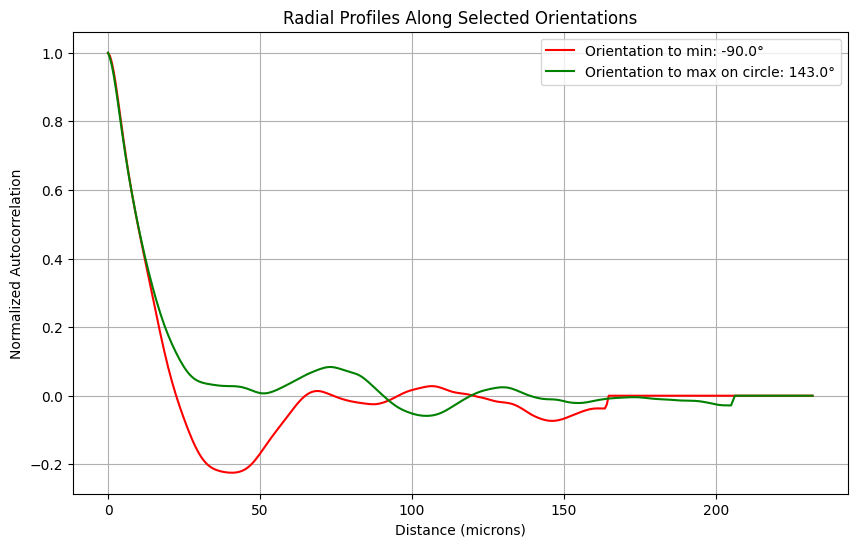

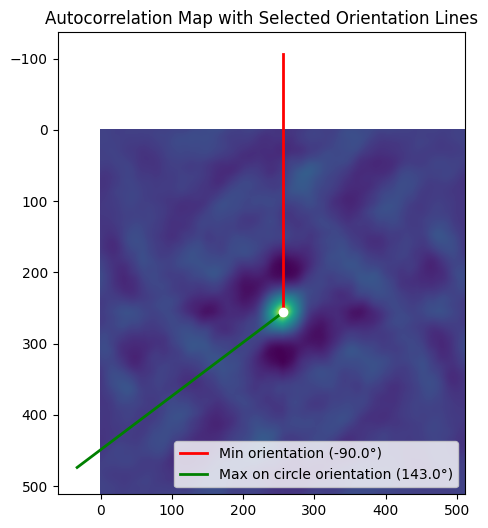

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from skimage.measure import profile_line

# Assume auto_corr_img is your normalized autocorrelation image (2D NumPy array),
# and pixel_size (micron per pixel) is available.
# Also assume auto_corr_img is a 2D numpy array.
# For example, get center of the autocorrelogram:
center_y, center_x = np.array(auto_corr_img.shape) // 2

# Create a coordinate grid for the image.
Y, X = np.indices(auto_corr_img.shape)
r_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

# Define an outer limit: only consider points within 100 µm from the center.
outer_limit_pixels = 100 / pixel_size  # convert 100 µm to pixels.

# Exclude a small central region (e.g., radius < 5 pixels) and outer region.
exclusion_mask = (r_from_center > 5) & (r_from_center <= outer_limit_pixels)

# 1. Find the smallest point (most negative value) within the allowed region.
neg_values = auto_corr_img[exclusion_mask]
min_val = np.min(neg_values)
min_coords = np.argwhere((auto_corr_img == min_val) & exclusion_mask)[0]
y_min, x_min = min_coords

# Compute orientation from center to this minimal point.
vec = np.array([x_min - center_x, y_min - center_y])
R = np.linalg.norm(vec)
orientation_min = np.arctan2(y_min - center_y, x_min - center_x)  # in radians

print("Minimum autocorrelation value:", min_val)
print("Distance R (pixels):", R)
print("Orientation to min (radians, degrees):", orientation_min, np.degrees(orientation_min))

# 2. Now, sample the circumference of a circle of radius R (centered at the image center)
num_samples = 360
angles = np.linspace(0, 2*np.pi, num_samples, endpoint=False)
circle_vals = []
for angle in angles:
    # Coordinates on the circle
    x_sample = center_x + R * np.cos(angle)
    y_sample = center_y + R * np.sin(angle)
    # Use map_coordinates for bilinear interpolation
    val = map_coordinates(auto_corr_img, [[y_sample], [x_sample]], order=1, mode='reflect')[0]
    circle_vals.append(val)
circle_vals = np.array(circle_vals)

max_val_on_circle = np.max(circle_vals)
max_index = np.argmax(circle_vals)
orientation_max = angles[max_index]  # orientation from center toward that max on circle

print("Maximum value on circle:", max_val_on_circle)
print("Orientation to max on circle (radians, degrees):", orientation_max, np.degrees(orientation_max))

# 3. Extract radial profiles along the two selected orientations.
# Define maximum length for profiles as the distance from center to the farthest corner.
max_length = np.sqrt(center_x**2 + center_y**2)

# Profile along orientation to the minimum (largest negative).
end_x1 = center_x + max_length * np.cos(orientation_min)
end_y1 = center_y + max_length * np.sin(orientation_min)
profile_min = profile_line(auto_corr_img, (center_y, center_x), (end_y1, end_x1),
                           order=1, mode='constant')

# Profile along orientation to the maximum on the circle.
end_x2 = center_x + max_length * np.cos(orientation_max)
end_y2 = center_y + max_length * np.sin(orientation_max)
profile_max = profile_line(auto_corr_img, (center_y, center_x), (end_y2, end_x2),
                           order=1, mode='constant')

# Create distance vector (in pixels)
distances = np.linspace(0, max_length, len(profile_min))
# Convert distances to microns.
distances_microns = distances * pixel_size

# 4. Plot the two 1D radial profiles.
plt.figure(figsize=(10,6))
plt.plot(distances_microns, profile_min, label=f"Orientation to min: {np.degrees(orientation_min):.1f}°", color='red')
plt.plot(distances_microns, profile_max, label=f"Orientation to max on circle: {np.degrees(orientation_max):.1f}°", color='green')
plt.xlabel("Distance (microns)")
plt.ylabel("Normalized Autocorrelation")
plt.title("Radial Profiles Along Selected Orientations")
plt.legend()
plt.grid(True)
plt.show()

# 5. Overlay the two orientation lines on the autocorrelation image.
plt.figure(figsize=(6,6))
plt.imshow(auto_corr_img, cmap='viridis')
# Line for orientation toward the min point.
plt.plot([center_x, center_x + max_length*np.cos(orientation_min)],
         [center_y, center_y + max_length*np.sin(orientation_min)],
         'r-', linewidth=2, label=f"Min orientation ({np.degrees(orientation_min):.1f}°)")
# Line for orientation toward the max on circle.
plt.plot([center_x, center_x + max_length*np.cos(orientation_max)],
         [center_y, center_y + max_length*np.sin(orientation_max)],
         'g-', linewidth=2, label=f"Max on circle orientation ({np.degrees(orientation_max):.1f}°)")
plt.scatter([center_x], [center_y], color='white', zorder=10)
plt.title("Autocorrelation Map with Selected Orientation Lines")
plt.legend()
plt.show()


Pixel size: 0.640221 micron/pixel
Mask bounding box: (697, 827, 2512, 2306)


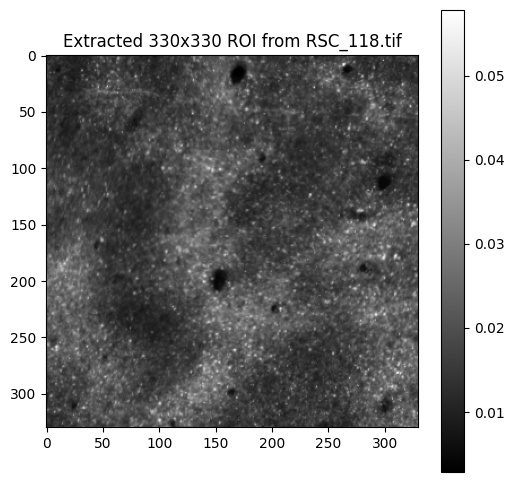

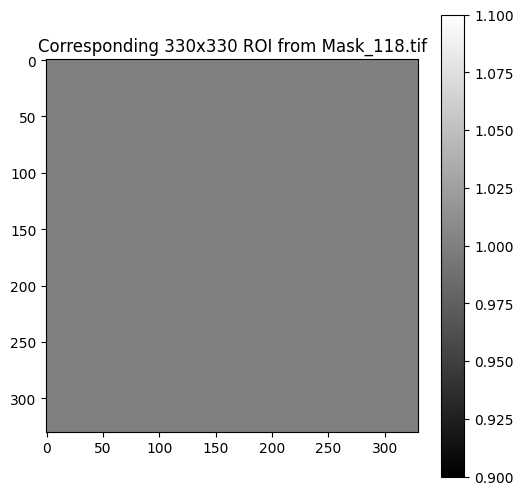

In [45]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, measure

# --- Step 1: Read the main image and the mask ---
rsc_img = tifffile.imread('RSC_118.tif')
mask_img = tifffile.imread('Mask_118.tif')

# Convert images to float for processing
rsc_img = img_as_float(rsc_img)
mask_img = img_as_float(mask_img)

# --- Step 2: Extract pixel size (micron per pixel) from RSC_118.tif metadata ---
with tifffile.TiffFile('RSC_118.tif') as tif:
    page = tif.pages[0]
    x_res_fraction = page.tags['XResolution'].value  # e.g., (640221, 1000000)
    # (Optionally also y_res_fraction; here we assume they are the same)
    pixel_size = x_res_fraction[0] / x_res_fraction[1]
    print("Pixel size:", pixel_size, "micron/pixel")

# --- Step 3: Process the mask ---
# Ensure the mask is binary (adjust threshold as needed)
mask_binary = mask_img > 0.5

# Label connected regions and choose the largest one
label_img = measure.label(mask_binary)
regions = measure.regionprops(label_img)
if not regions:
    raise ValueError("No regions found in the mask.")
largest_region = max(regions, key=lambda r: r.area)
minr, minc, maxr, maxc = largest_region.bbox
print("Mask bounding box:", (minr, minc, maxr, maxc))

# --- Step 4: Compute the ROI coordinates ---
roi_size = 330  # ROI size in pixels
# Compute the center of the bounding box of the mask region
bb_center_row = (minr + maxr) // 2
bb_center_col = (minc + maxc) // 2

# Define the top-left corner of the ROI so that the ROI is centered at the bounding-box center
roi_y0 = bb_center_row - roi_size // 2
roi_x0 = bb_center_col - roi_size // 2

# Ensure the ROI stays within the bounds of the main image
img_height, img_width = rsc_img.shape
roi_y0 = max(0, min(roi_y0, img_height - roi_size))
roi_x0 = max(0, min(roi_x0, img_width - roi_size))

# --- Step 5: Extract the ROI from the main image and mask ---
roi = rsc_img[roi_y0:roi_y0+roi_size, roi_x0:roi_x0+roi_size]
mask_roi = mask_binary[roi_y0:roi_y0+roi_size, roi_x0:roi_x0+roi_size]

# --- Step 6: Display the extracted ROIs for verification ---
plt.figure(figsize=(6,6))
plt.imshow(roi, cmap='gray')
plt.title("Extracted 330x330 ROI from RSC_118.tif")
plt.colorbar()
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(mask_roi, cmap='gray')
plt.title("Corresponding 330x330 ROI from Mask_118.tif")
plt.colorbar()
plt.show()

# Now you can pass the variable 'roi' (330x330) to your radial profile analysis code.


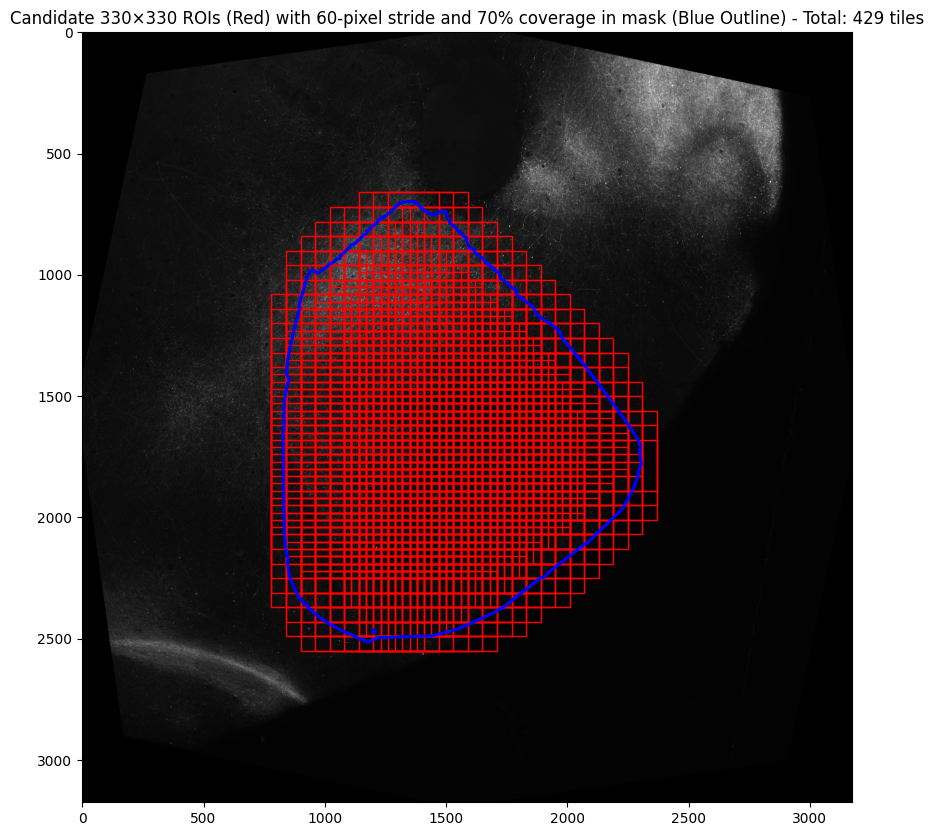

In [31]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.measure import find_contours

# Parameters (you can adjust these)
roi_size = 330
stride = 60  # slide window by 50 pixels (update comment if needed)
coverage_threshold = 0.7  # require at least 50% of ROI pixels to be within the mask

plt.figure(figsize=(10, 10))
plt.imshow(rsc_img, cmap='gray')
ax = plt.gca()

# Counter for candidate ROIs
num_tiles = 0

# Loop over candidate ROI positions using the defined stride.
for y in range(0, rsc_img.shape[0] - roi_size + 1, stride):
    for x in range(0, rsc_img.shape[1] - roi_size + 1, stride):
        # Extract the candidate ROI from the binary mask.
        roi_mask = mask_binary[y:y+roi_size, x:x+roi_size]
        # Calculate the fraction of pixels in the ROI that fall inside the mask.
        fraction = roi_mask.mean()
        if fraction >= coverage_threshold:
            # Increment counter and draw the rectangle.
            num_tiles += 1
            rect = Rectangle((x, y), roi_size, roi_size, linewidth=1, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

# Compute the contours (outline) of the mask and overlay them.
contours = find_contours(mask_binary, level=0.5)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')

# Create a title that includes variables and the number of candidate tiles.
title_text = (f"Candidate {roi_size}×{roi_size} ROIs (Red) with {stride}-pixel stride and "
              f"{coverage_threshold*100:.0f}% coverage in mask (Blue Outline) - Total: {num_tiles} tiles")
plt.title(title_text)
plt.show()


Pixel size: 0.640221 micron/pixel
Found 12488 candidate ROIs within the mask.
          x     y  r_half_pixels  r_half_microns  first_negative_amp  \
0      1180   710       7.061213        4.520737           -0.042303   
1      1190   710       7.258020        4.646737           -0.042851   
2      1200   710       7.334062        4.695421           -0.047543   
3      1210   710       7.362810        4.713826           -0.048141   
4      1220   710       7.649207        4.897183           -0.050222   
...     ...   ...            ...             ...                 ...   
12483  1170  2190      12.905978        8.262678           -0.060808   
12484  1180  2190      12.404107        7.941370           -0.060798   
12485  1190  2190      12.340544        7.900675           -0.063867   
12486  1200  2190      12.517683        8.014084           -0.069527   
12487  1210  2190      12.271082        7.856204           -0.070959   

       second_positive_distance_pixels  second_positive_d

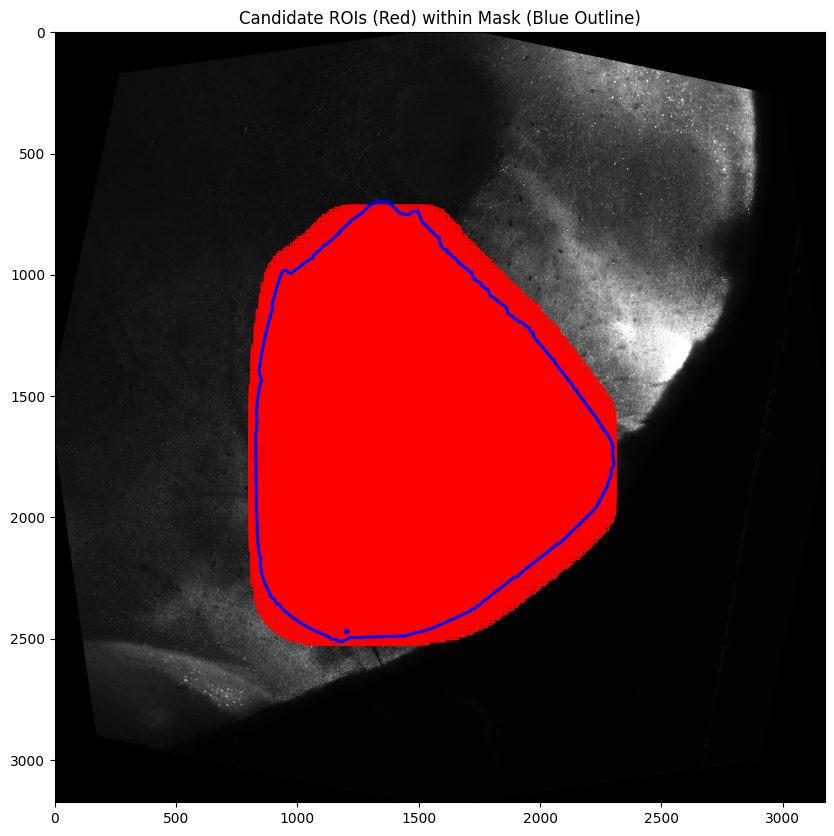

CPU times: user 28.6 s, sys: 20.7 s, total: 49.3 s
Wall time: 3min 52s


In [1]:
%%time
## parallel processingでradial profileとmetrics(orientation除く)を各tileにつき求める
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage import img_as_float, measure
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2, ifft2, fftshift
import pandas as pd

# CPU parallel processing:
import multiprocessing as mp

# GPU imports for background subtraction acceleration
import cupy as cp
import cupyx.scipy.ndimage as cndimage

#########################################
# Functions for Autocorrelation Analysis
#########################################

def next_power_of_two(n):
    return 2**int(np.ceil(np.log2(n)))

def bandpass_filter(image, sigma_small=3, sigma_large=40):
    g_small = gaussian_filter(image, sigma=sigma_small)
    g_large = gaussian_filter(image, sigma=sigma_large)
    return g_small - g_large

def pad_image_with_mean(image, pad_size):
    h, w = image.shape
    padded = np.full((pad_size, pad_size), np.mean(image), dtype=image.dtype)
    offset_y = (pad_size - h) // 2
    offset_x = (pad_size - w) // 2
    padded[offset_y:offset_y+h, offset_x:offset_x+w] = image
    return padded, offset_x, offset_y

def compute_autocorrelation(image):
    F = fft2(image)
    auto_corr = ifft2(np.abs(F)**2).real
    return fftshift(auto_corr)

def radial_profile(data, center, max_radius):
    y, x = np.indices(data.shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    radial_mean = []
    radii = np.arange(0, max_radius+1)
    for r_val in radii:
        mask = (r >= r_val) & (r < r_val+1)
        if np.any(mask):
            radial_mean.append(data[mask].mean())
        else:
            radial_mean.append(np.nan)
    return radii, np.array(radial_mean)

def background_subtract_gpu(image, selem_radius=50):
    image_gpu = cp.asarray(image)
    y, x = cp.ogrid[-selem_radius:selem_radius+1, -selem_radius:selem_radius+1]
    selem = (x**2 + y**2) <= selem_radius**2
    selem = selem.astype(cp.bool_)
    result_gpu = cndimage.white_tophat(image_gpu, footprint=selem)
    return cp.asnumpy(result_gpu)

def autocorrelation_radial_profile(image, do_bandpass=True, sigma_small=3, sigma_large=40,
                                   pad_factor=1.3, radial_limit_factor=0.3, debug=False,
                                   subtract_background=False, rolling_radius=50):
    if subtract_background:
        image = background_subtract_gpu(image, selem_radius=rolling_radius)
    if do_bandpass:
        image_filtered = bandpass_filter(image, sigma_small, sigma_large)
    else:
        image_filtered = image.copy()
    
    image_mean = np.mean(image_filtered)
    h, w = image_filtered.shape
    n_pixels = h * w

    target_size = int(np.ceil(pad_factor * max(w, h)))
    new_size = next_power_of_two(target_size)
    padded_image, _, _ = pad_image_with_mean(image_filtered, new_size)
    
    auto_corr = compute_autocorrelation(padded_image)
    auto_corr -= n_pixels * (image_mean**2)
    
    mask = np.ones((h, w), dtype=float)
    padded_mask, _, _ = pad_image_with_mean(mask, new_size)
    ref_corr = compute_autocorrelation(padded_mask)
    ref_corr[ref_corr == 0] = 1.0
    auto_corr_corrected = auto_corr / ref_corr
    
    center = new_size // 2
    norm_value = auto_corr_corrected[center, center]
    if norm_value != 0:
        auto_corr_corrected /= norm_value
    else:
        print("Warning: norm_value is zero; skipping normalization.")
    
    max_radius = new_size // 2
    radii, profile = radial_profile(auto_corr_corrected, (center, center), max_radius)
    
    if debug:
        plt.figure(); plt.plot(radii, profile, marker='o'); 
        plt.title("Radial Profile"); plt.xlabel("Radius (pixels)"); plt.ylabel("Normalized Autocorrelation");
        plt.grid(True); plt.show()
    
    return radii, profile, auto_corr_corrected

##############################################
# Global variables for multiprocessing workers
##############################################
# These globals will be set in the __main__ block so that the worker processes can use them.
global_rsc_img = None
global_pixel_size = None
roi_size = 330

def process_tile(tile_coords):
    x, y = tile_coords
    roi = global_rsc_img[y:y+roi_size, x:x+roi_size]
    radii, profile, _ = autocorrelation_radial_profile(roi, do_bandpass=True, sigma_small=3, sigma_large=40,
                                                       pad_factor=1.3, radial_limit_factor=0.3,
                                                       debug=False, subtract_background=True, rolling_radius=50)
    # Metric 1: 50% width of the first peak
    r_half = None
    for i in range(1, len(profile)):
        if profile[i] <= 0.5:
            r_half = radii[i-1] + (0.5 - profile[i-1])*(radii[i]-radii[i-1])/(profile[i]-profile[i-1])
            break
    # Metric 2: Amplitude of the first negative peak
    first_negative_amp = None
    for i in range(1, len(profile)-1):
        if profile[i] < 0 and profile[i] < profile[i-1] and profile[i] < profile[i+1]:
            first_negative_amp = profile[i]
            break
    # Metric 3: Distance to the second positive peak (first local max above 0 after center)
    second_positive_distance = None
    for i in range(1, len(profile)-1):
        if profile[i] > 0 and profile[i] > profile[i-1] and profile[i] > profile[i+1]:
            second_positive_distance = radii[i]
            break
    return {
        'x': x,
        'y': y,
        'r_half_pixels': r_half,
        'r_half_microns': r_half * global_pixel_size if r_half is not None else None,
        'first_negative_amp': first_negative_amp,
        'second_positive_distance_pixels': second_positive_distance,
        'second_positive_distance_microns': second_positive_distance * global_pixel_size if second_positive_distance is not None else None
    }

#######################################
# Main code: Tiling and Metrics Extraction
#######################################

if __name__ == "__main__":
    # File paths
    rsc_path = 'RSC_118.tif'
    mask_path = 'Mask_118.tif'
    
    # Read main image and mask; convert to float.
    rsc_img = tifffile.imread(rsc_path)
    mask_img = tifffile.imread(mask_path)
    rsc_img = img_as_float(rsc_img)
    mask_img = img_as_float(mask_img)
    
    # Extract pixel size from main image metadata (using XResolution)
    with tifffile.TiffFile(rsc_path) as tif:
        page = tif.pages[0]
        x_res_fraction = page.tags['XResolution'].value
        pixel_size = x_res_fraction[0] / x_res_fraction[1]
        print("Pixel size:", pixel_size, "micron/pixel")
    
    # Set globals for worker processes.
    global_rsc_img = rsc_img
    global_pixel_size = pixel_size
    
    # Create a binary mask from mask image.
    mask_binary = mask_img > 0.5
    
    # Tiling parameters
    stride = 10  # slide window by 10 pixels
    coverage_threshold = 0.9  # require at least 90% mask coverage in ROI
    
    # Collect candidate tile positions
    tile_positions = []
    for y in range(0, rsc_img.shape[0] - roi_size + 1, stride):
        for x in range(0, rsc_img.shape[1] - roi_size + 1, stride):
            roi_mask = mask_binary[y:y+roi_size, x:x+roi_size]
            if roi_mask.mean() >= coverage_threshold:
                tile_positions.append((x, y))
    
    print(f"Found {len(tile_positions)} candidate ROIs within the mask.")
    
    # Use multiprocessing.Pool to process candidate ROIs in parallel.
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(process_tile, tile_positions)
    
    metrics_df = pd.DataFrame(results)
    print(metrics_df)
    
    # Visualization: draw candidate ROI rectangles and overlay mask outline.
    import matplotlib.patches as patches
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(rsc_img, cmap='gray')
    for (x, y) in tile_positions:
        rect = patches.Rectangle((x, y), roi_size, roi_size, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
    contours = find_contours(mask_binary, level=0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
    ax.set_title("Candidate ROIs (Red) within Mask (Blue Outline)")
    plt.show()


In [2]:
metrics_df

x     y  r_half_pixels  r_half_microns  first_negative_amp  \
0      1180   710       7.061213        4.520737           -0.042303   
1      1190   710       7.258020        4.646737           -0.042851   
2      1200   710       7.334062        4.695421           -0.047543   
3      1210   710       7.362810        4.713826           -0.048141   
4      1220   710       7.649207        4.897183           -0.050222   
...     ...   ...            ...             ...                 ...   
12483  1170  2190      12.905978        8.262678           -0.060808   
12484  1180  2190      12.404107        7.941370           -0.060798   
12485  1190  2190      12.340544        7.900675           -0.063867   
12486  1200  2190      12.517683        8.014084           -0.069527   
12487  1210  2190      12.271082        7.856204           -0.070959   

       second_positive_distance_pixels  second_positive_distance_microns  
0                                   86                         55.059006  
1                                   88                         56.339448  
2                                   78                         49.937238  
3                                   81                         51.857901  
4                                   83                         53.138343  
...                                ...                               ...  
12483                              113                         72.344973  
12484                              113                         72.344973  
12485                              113                         72.344973  
12486                              109                         69.784089  
12487                              104                         66.582984  

[12488 rows x 7 columns]

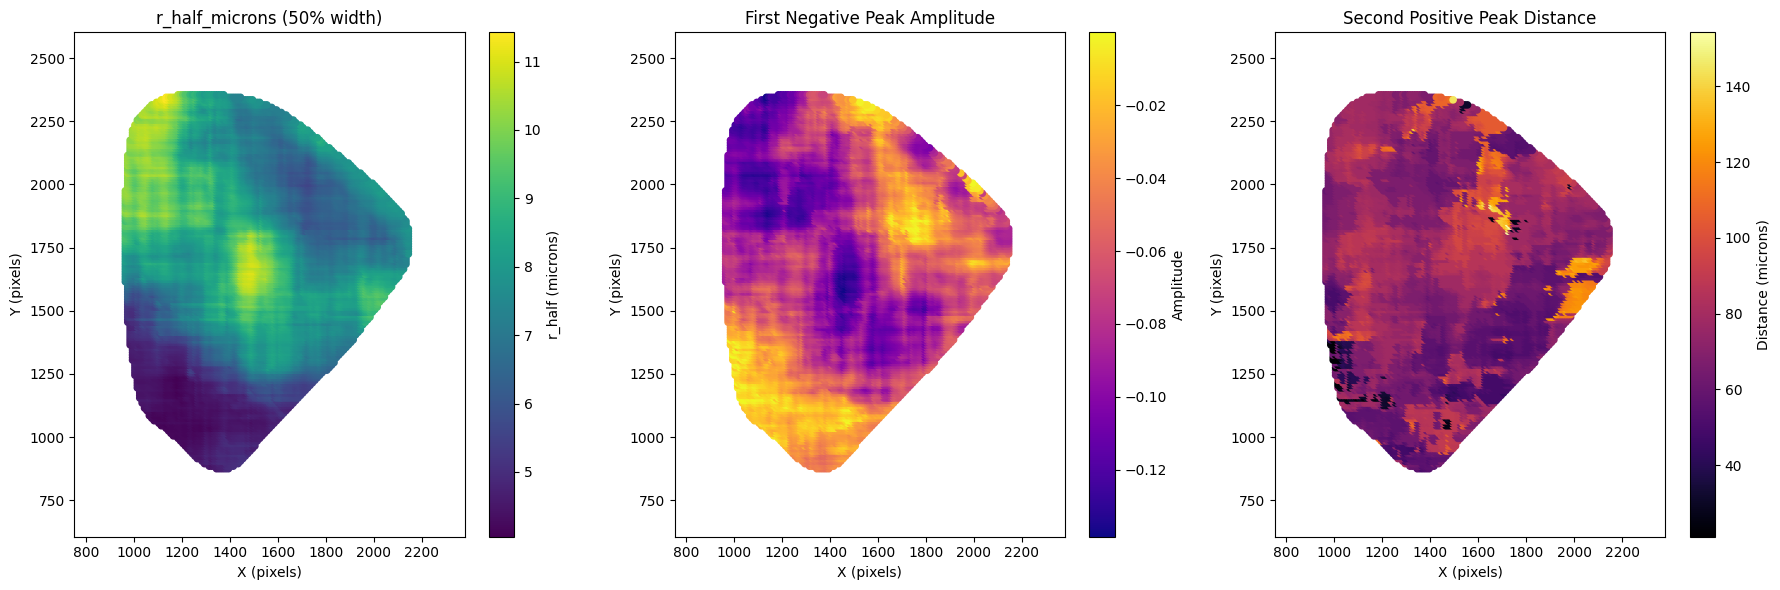

In [4]:
## radial profileから求めたmetricsをmap (orientationなし)
import matplotlib.pyplot as plt
from skimage.measure import find_contours

# Compute ROI center coordinates (assuming roi_size is defined)
roi_center_x = metrics_df['x'] + roi_size/2
roi_center_y = metrics_df['y'] + roi_size/2

# Extract mask contours
contours = find_contours(mask_binary, level=0.5)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: r_half_microns (50% width)
sc1 = axs[0].scatter(roi_center_x, roi_center_y, c=metrics_df['r_half_microns'], cmap='viridis', s=20)
for contour in contours:
    axs[0].plot(contour[:, 1], contour[:, 0], color='white', linewidth=2)
axs[0].set_title("r_half_microns (50% width)")
axs[0].set_xlabel("X (pixels)")
axs[0].set_ylabel("Y (pixels)")
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label("r_half (microns)")

# Plot 2: first_negative_amp (amplitude of first negative peak)
sc2 = axs[1].scatter(roi_center_x, roi_center_y, c=metrics_df['first_negative_amp'], cmap='plasma', s=20)
for contour in contours:
    axs[1].plot(contour[:, 1], contour[:, 0], color='white', linewidth=2)
axs[1].set_title("First Negative Peak Amplitude")
axs[1].set_xlabel("X (pixels)")
axs[1].set_ylabel("Y (pixels)")
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label("Amplitude")

# Plot 3: second_positive_distance_microns (distance to second positive peak)
sc3 = axs[2].scatter(roi_center_x, roi_center_y, c=metrics_df['second_positive_distance_microns'], cmap='inferno', s=20)
for contour in contours:
    axs[2].plot(contour[:, 1], contour[:, 0], color='white', linewidth=2)
axs[2].set_title("Second Positive Peak Distance")
axs[2].set_xlabel("X (pixels)")
axs[2].set_ylabel("Y (pixels)")
cbar3 = fig.colorbar(sc3, ax=axs[2])
cbar3.set_label("Distance (microns)")

plt.tight_layout()
plt.show()


Pixel size: 0.640221 micron/pixel
Found 266 candidate ROIs within the mask.
        x     y  r_half_pixels  r_half_microns  first_negative_amp  \
0    1066   656       6.649926        4.257422           -0.035773   
1    1148   656       7.112188        4.553372           -0.052164   
2    1230   656       7.824963        5.009705           -0.055255   
3    1312   656       7.709567        4.935826           -0.040175   
4     984   738       6.717580        4.300736           -0.026992   
..    ...   ...            ...             ...                 ...   
261   984  2296      15.546321        9.953081           -0.085956   
262  1066  2296      13.964164        8.940151           -0.103827   
263  1148  2296      13.426634        8.596013           -0.090328   
264  1230  2296      13.157683        8.423825           -0.049309   
265  1312  2296      13.166736        8.429621           -0.001601   

     second_positive_distance_pixels  second_positive_distance_microns  \
0        

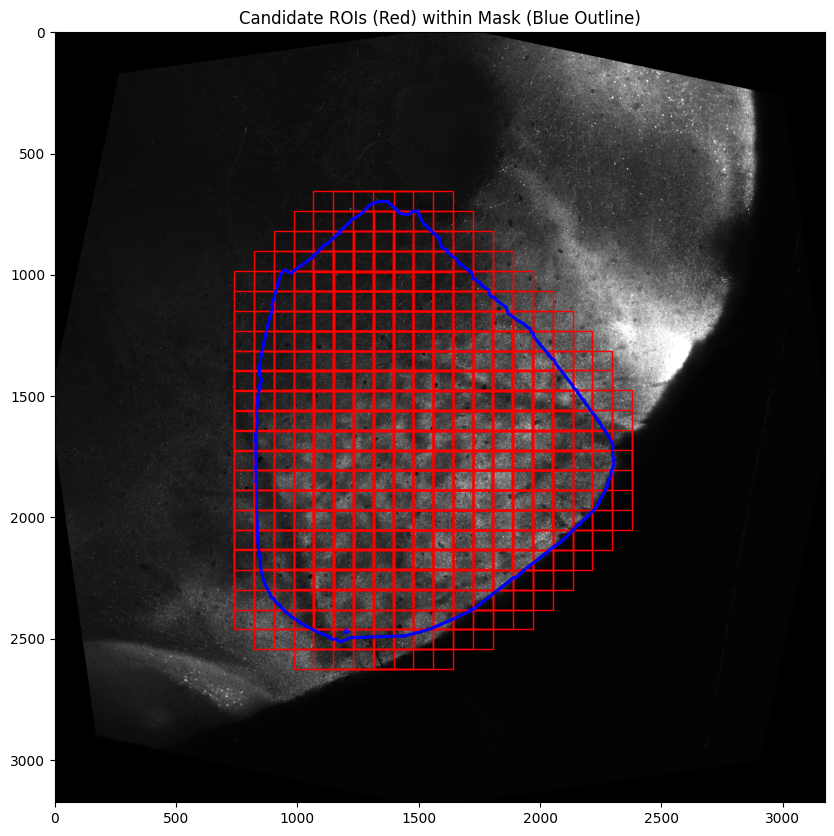

CPU times: user 9.89 s, sys: 22.6 s, total: 32.5 s
Wall time: 30.6 s


In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage import img_as_float, measure
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter, map_coordinates
from numpy.fft import fft2, ifft2, fftshift
import pandas as pd

# CPU parallel processing:
import multiprocessing as mp

# GPU imports for background subtraction acceleration
import cupy as cp
import cupyx.scipy.ndimage as cndimage

#########################################
# Functions for Autocorrelation Analysis
#########################################

def next_power_of_two(n):
    return 2**int(np.ceil(np.log2(n)))

def bandpass_filter(image, sigma_small=3, sigma_large=40):
    g_small = gaussian_filter(image, sigma=sigma_small)
    g_large = gaussian_filter(image, sigma=sigma_large)
    return g_small - g_large

def pad_image_with_mean(image, pad_size):
    h, w = image.shape
    padded = np.full((pad_size, pad_size), np.mean(image), dtype=image.dtype)
    offset_y = (pad_size - h) // 2
    offset_x = (pad_size - w) // 2
    padded[offset_y:offset_y+h, offset_x:offset_x+w] = image
    return padded, offset_x, offset_y

def compute_autocorrelation(image):
    F = fft2(image)
    auto_corr = ifft2(np.abs(F)**2).real
    return fftshift(auto_corr)

def radial_profile(data, center, max_radius):
    y, x = np.indices(data.shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    radial_mean = []
    radii = np.arange(0, max_radius+1)
    for r_val in radii:
        mask = (r >= r_val) & (r < r_val+1)
        if np.any(mask):
            radial_mean.append(data[mask].mean())
        else:
            radial_mean.append(np.nan)
    return radii, np.array(radial_mean)

def background_subtract_gpu(image, selem_radius=50):
    image_gpu = cp.asarray(image)
    y, x = cp.ogrid[-selem_radius:selem_radius+1, -selem_radius:selem_radius+1]
    selem = (x**2 + y**2) <= selem_radius**2
    selem = selem.astype(cp.bool_)
    result_gpu = cndimage.white_tophat(image_gpu, footprint=selem)
    return cp.asnumpy(result_gpu)

def autocorrelation_radial_profile(image, do_bandpass=True, sigma_small=3, sigma_large=40,
                                   pad_factor=1.3, radial_limit_factor=0.3, debug=False,
                                   subtract_background=False, rolling_radius=50):
    if subtract_background:
        image = background_subtract_gpu(image, selem_radius=rolling_radius)
    if do_bandpass:
        image_filtered = bandpass_filter(image, sigma_small, sigma_large)
    else:
        image_filtered = image.copy()
    
    image_mean = np.mean(image_filtered)
    h, w = image_filtered.shape
    n_pixels = h * w

    target_size = int(np.ceil(pad_factor * max(w, h)))
    new_size = next_power_of_two(target_size)
    if debug:
        print("Padded size:", new_size)
    padded_image, _, _ = pad_image_with_mean(image_filtered, new_size)
    if debug:
        plt.figure(); plt.imshow(padded_image, cmap='gray'); plt.title("Padded Image"); plt.colorbar(); plt.show()
    
    auto_corr = compute_autocorrelation(padded_image)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis'); plt.title("Autocorrelation (Raw)"); plt.colorbar(); plt.show()
    
    auto_corr -= n_pixels * (image_mean**2)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis'); plt.title("After Mean Subtraction"); plt.colorbar(); plt.show()
    
    mask = np.ones((h, w), dtype=float)
    padded_mask, _, _ = pad_image_with_mean(mask, new_size)
    ref_corr = compute_autocorrelation(padded_mask)
    ref_corr[ref_corr == 0] = 1.0
    auto_corr_corrected = auto_corr / ref_corr
    if debug:
        plt.figure(); plt.imshow(auto_corr_corrected, cmap='viridis'); plt.title("Corrected Autocorrelation"); plt.colorbar(); plt.show()
    
    center = new_size // 2
    norm_value = auto_corr_corrected[center, center]
    if debug:
        print("Normalization value (center):", norm_value)
    if norm_value != 0:
        auto_corr_corrected /= norm_value
    else:
        print("Warning: norm_value is zero; skipping normalization.")
    
    max_radius = new_size // 2
    radii, profile = radial_profile(auto_corr_corrected, (center, center), max_radius)
    if debug:
        plt.figure(); plt.plot(radii, profile, marker='o'); 
        plt.title("Radial Profile"); plt.xlabel("Radius (pixels)"); plt.ylabel("Normalized Autocorrelation");
        plt.grid(True); plt.show()
    
    return radii, profile, auto_corr_corrected

##############################################
# Global variables for multiprocessing workers
##############################################
global_rsc_img = None
global_pixel_size = None
roi_size = 330

def process_tile(tile_coords):
    x, y = tile_coords
    roi = global_rsc_img[y:y+roi_size, x:x+roi_size]
    # Get autocorrelation map from ROI
    radii, profile, auto_corr_map = autocorrelation_radial_profile(roi, do_bandpass=True, sigma_small=3, sigma_large=40,
                                                                   pad_factor=1.3, radial_limit_factor=0.3,
                                                                   debug=False, subtract_background=True, rolling_radius=50)
    # Metric 1: 50% width of the first peak along the 1D profile
    r_half = None
    for i in range(1, len(profile)):
        if profile[i] <= 0.5:
            r_half = radii[i-1] + (0.5 - profile[i-1])*(radii[i]-radii[i-1])/(profile[i]-profile[i-1])
            break
    
    # Metric 2: Amplitude of the first negative peak (value below 0)
    first_negative_amp = None
    for i in range(1, len(profile)-1):
        if profile[i] < 0 and profile[i] < profile[i-1] and profile[i] < profile[i+1]:
            first_negative_amp = profile[i]
            break
    
    # Metric 3: Distance to the second positive peak (first local max above 0 after center)
    second_positive_distance = None
    for i in range(1, len(profile)-1):
        if profile[i] > 0 and profile[i] > profile[i-1] and profile[i] > profile[i+1]:
            second_positive_distance = radii[i]
            break

    # Metric 4: Orientation along the line.
    # Compute the center of the autocorrelation map.
    new_size_map = auto_corr_map.shape[0]  # assume square
    center_pt = np.array([new_size_map//2, new_size_map//2])
    Y, X = np.indices(auto_corr_map.shape)
    r_map = np.sqrt((X - center_pt[1])**2 + (Y - center_pt[0])**2)
    exclusion_mask = r_map > 5  # exclude center region
    # Find the most negative value in auto_corr_map outside the center.
    neg_vals = auto_corr_map[exclusion_mask]
    min_val = np.min(neg_vals)
    min_coords = np.argwhere((auto_corr_map == min_val) & exclusion_mask)
    if min_coords.shape[0] > 0:
        min_coord = min_coords[0]
    else:
        min_coord = center_pt
    # Orientation from center to the most negative point.
    orientation_min = np.arctan2(min_coord[0] - center_pt[0], min_coord[1] - center_pt[1])
    # For orientation, we want the absolute value modulo 180.
    orientation_min_degrees = np.degrees(orientation_min) % 180

    # Also, sample points on a circle of radius R (distance from center to min_coord) to get orientation_max.
    vec = np.array([min_coord[1] - center_pt[1], min_coord[0] - center_pt[0]])
    R_val = np.linalg.norm(vec)
    num_samples = 360
    angles = np.linspace(0, 2*np.pi, num_samples, endpoint=False)
    circle_vals = []
    for angle in angles:
        x_sample = center_pt[1] + R_val * np.cos(angle)
        y_sample = center_pt[0] + R_val * np.sin(angle)
        val = map_coordinates(auto_corr_map, [[y_sample], [x_sample]], order=1, mode='reflect')[0]
        circle_vals.append(val)
    circle_vals = np.array(circle_vals)
    max_index = np.argmax(circle_vals)
    orientation_max = angles[max_index]  # in radians
    orientation_max_degrees = np.degrees(orientation_max) % 180

    return {
        'x': x,
        'y': y,
        'r_half_pixels': r_half,
        'r_half_microns': r_half * global_pixel_size if r_half is not None else None,
        'first_negative_amp': first_negative_amp,
        'second_positive_distance_pixels': second_positive_distance,
        'second_positive_distance_microns': second_positive_distance * global_pixel_size if second_positive_distance is not None else None,
        'orientation_max_radians': orientation_max,
        'orientation_max_degrees': orientation_max_degrees,
        'orientation_min_radians': orientation_min,
        'orientation_min_degrees': orientation_min_degrees
    }

#######################################
# Main code: Tiling and Metrics Extraction
#######################################
if __name__ == "__main__":
    # File paths
    rsc_path = 'RSC_118.tif'
    mask_path = 'Mask_118.tif'
    
    # Read main image and mask; convert to float.
    rsc_img = tifffile.imread(rsc_path)
    mask_img = tifffile.imread(mask_path)
    rsc_img = img_as_float(rsc_img)
    mask_img = img_as_float(mask_img)
    
    # Extract pixel size from main image metadata (using XResolution)
    with tifffile.TiffFile(rsc_path) as tif:
        page = tif.pages[0]
        x_res_fraction = page.tags['XResolution'].value
        pixel_size = x_res_fraction[0] / x_res_fraction[1]
        print("Pixel size:", pixel_size, "micron/pixel")
    
    # Set globals for worker processes.
    global_rsc_img = rsc_img
    global_pixel_size = pixel_size
    
    # Create a binary mask from mask image.
    mask_binary = mask_img > 0.5
    
    # Tiling parameters
    stride = 82  # adjust as needed
    coverage_threshold = 0.5  # require at least 50% mask coverage in ROI
    
    # Collect candidate tile positions
    tile_positions = []
    for y in range(0, rsc_img.shape[0] - roi_size + 1, stride):
        for x in range(0, rsc_img.shape[1] - roi_size + 1, stride):
            roi_mask = mask_binary[y:y+roi_size, x:x+roi_size]
            if roi_mask.mean() >= coverage_threshold:
                tile_positions.append((x, y))
    
    print(f"Found {len(tile_positions)} candidate ROIs within the mask.")
    
    # Use multiprocessing.Pool to process candidate ROIs in parallel.
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(process_tile, tile_positions)
    
    metrics_df = pd.DataFrame(results)
    print(metrics_df)
    
    # Visualization: draw candidate ROI rectangles and overlay mask outline.
    import matplotlib.patches as patches
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(rsc_img, cmap='gray')
    for (x, y) in tile_positions:
        rect = patches.Rectangle((x, y), roi_size, roi_size, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
    contours = find_contours(mask_binary, level=0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
    ax.set_title("Candidate ROIs (Red) within Mask (Blue Outline)")
    plt.show()
    
    # Save or further process metrics_df as needed.


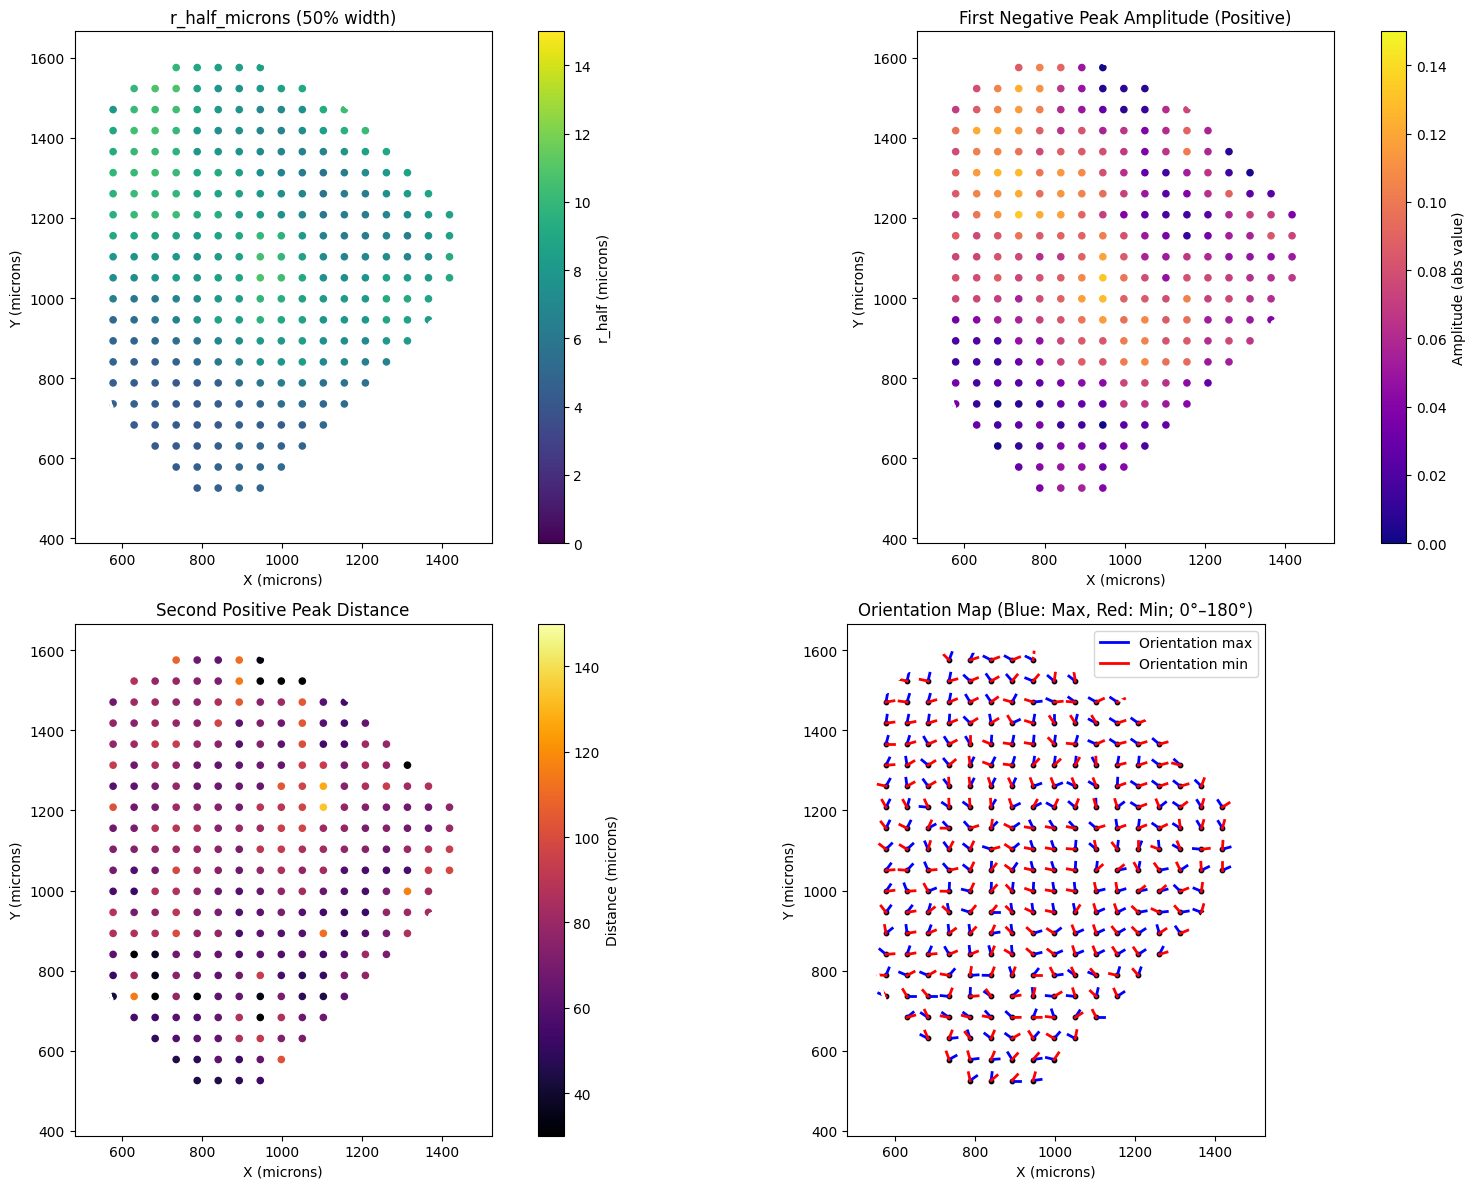

In [2]:
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import numpy as np
from matplotlib.lines import Line2D

# Adjust orientation_max_degrees and orientation_min_degrees to range [0, 180)
metrics_df['orientation_max_degrees'] = metrics_df['orientation_max_degrees'] % 180
metrics_df['orientation_max_radians'] = np.deg2rad(metrics_df['orientation_max_degrees'])
metrics_df['orientation_min_degrees'] = metrics_df['orientation_min_degrees'] % 180
metrics_df['orientation_min_radians'] = np.deg2rad(metrics_df['orientation_min_degrees'])

# Compute ROI center coordinates (converted to microns)
roi_center_x = (metrics_df['x'] + roi_size/2) * pixel_size
roi_center_y = (metrics_df['y'] + roi_size/2) * pixel_size

# Convert first_negative_amp to positive by multiplying by -1
first_negative_amp_positive = -metrics_df['first_negative_amp']

# Extract mask contours from the binary mask and convert to microns.
contours = find_contours(mask_binary, level=0.5)
contours_microns = [contour * pixel_size for contour in contours]

# Create a 2x2 subplot layout.
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.ravel()  # flatten to 1D array

# Set fixed ranges for the color maps (adjust as needed)
vmin_rhalf, vmax_rhalf = 0, 15           # for r_half_microns
vmin_neg, vmax_neg = 0, 0.15             # for first_negative_amp (converted positive)
vmin_second, vmax_second = 30, 150       # for second_positive_distance_microns

# Panel 1: r_half_microns (50% width)
sc1 = axs[0].scatter(roi_center_x, roi_center_y, 
                     c=metrics_df['r_half_microns'], cmap='viridis', s=20,
                     vmin=vmin_rhalf, vmax=vmax_rhalf)
for contour in contours_microns:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[0].set_title("r_half_microns (50% width)")
axs[0].set_xlabel("X (microns)")
axs[0].set_ylabel("Y (microns)")
axs[0].set_aspect('equal', adjustable='box')
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label("r_half (microns)")

# Panel 2: first_negative_amp (converted to positive)
sc2 = axs[1].scatter(roi_center_x, roi_center_y, 
                     c=first_negative_amp_positive, cmap='plasma', s=20,
                     vmin=vmin_neg, vmax=vmax_neg)
for contour in contours_microns:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[1].set_title("First Negative Peak Amplitude (Positive)")
axs[1].set_xlabel("X (microns)")
axs[1].set_ylabel("Y (microns)")
axs[1].set_aspect('equal', adjustable='box')
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label("Amplitude (abs value)")

# Panel 3: second_positive_distance_microns
sc3 = axs[2].scatter(roi_center_x, roi_center_y, 
                     c=metrics_df['second_positive_distance_microns'], cmap='inferno', s=20,
                     vmin=vmin_second, vmax=vmax_second)
for contour in contours_microns:
    axs[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[2].set_title("Second Positive Peak Distance")
axs[2].set_xlabel("X (microns)")
axs[2].set_ylabel("Y (microns)")
axs[2].set_aspect('equal', adjustable='box')
cbar3 = fig.colorbar(sc3, ax=axs[2])
cbar3.set_label("Distance (microns)")

# Panel 4: Orientation Map with Tilted Lines for Both Metrics
line_length = 20  # fixed length in microns for drawn lines

# Compute endpoints for orientation_max lines (blue)
angles_max = metrics_df['orientation_max_radians']  # already in radians [0, π)
x_end_max = roi_center_x + line_length * np.cos(angles_max)
y_end_max = roi_center_y + line_length * np.sin(angles_max)

# Compute endpoints for orientation_min lines (red)
angles_min = metrics_df['orientation_min_radians']  # already in radians [0, π)
x_end_min = roi_center_x + line_length * np.cos(angles_min)
y_end_min = roi_center_y + line_length * np.sin(angles_min)

# Plot orientation_max lines in blue.
for xc, yc, xe, ye in zip(roi_center_x, roi_center_y, x_end_max, y_end_max):
    axs[3].plot([xc, xe], [yc, ye], color='blue', linewidth=2)
# Plot orientation_min lines in red.
for xc, yc, xe, ye in zip(roi_center_x, roi_center_y, x_end_min, y_end_min):
    axs[3].plot([xc, xe], [yc, ye], color='red', linewidth=2)
# Plot ROI centers as small black dots.
axs[3].scatter(roi_center_x, roi_center_y, color='black', s=10)
for contour in contours_microns:
    axs[3].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[3].set_title("Orientation Map (Blue: Max, Red: Min; 0°–180°)")
axs[3].set_xlabel("X (microns)")
axs[3].set_ylabel("Y (microns)")
axs[3].set_aspect('equal', adjustable='box')
# Create a custom legend.
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Orientation max'),
                   Line2D([0], [0], color='red', lw=2, label='Orientation min')]
axs[3].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


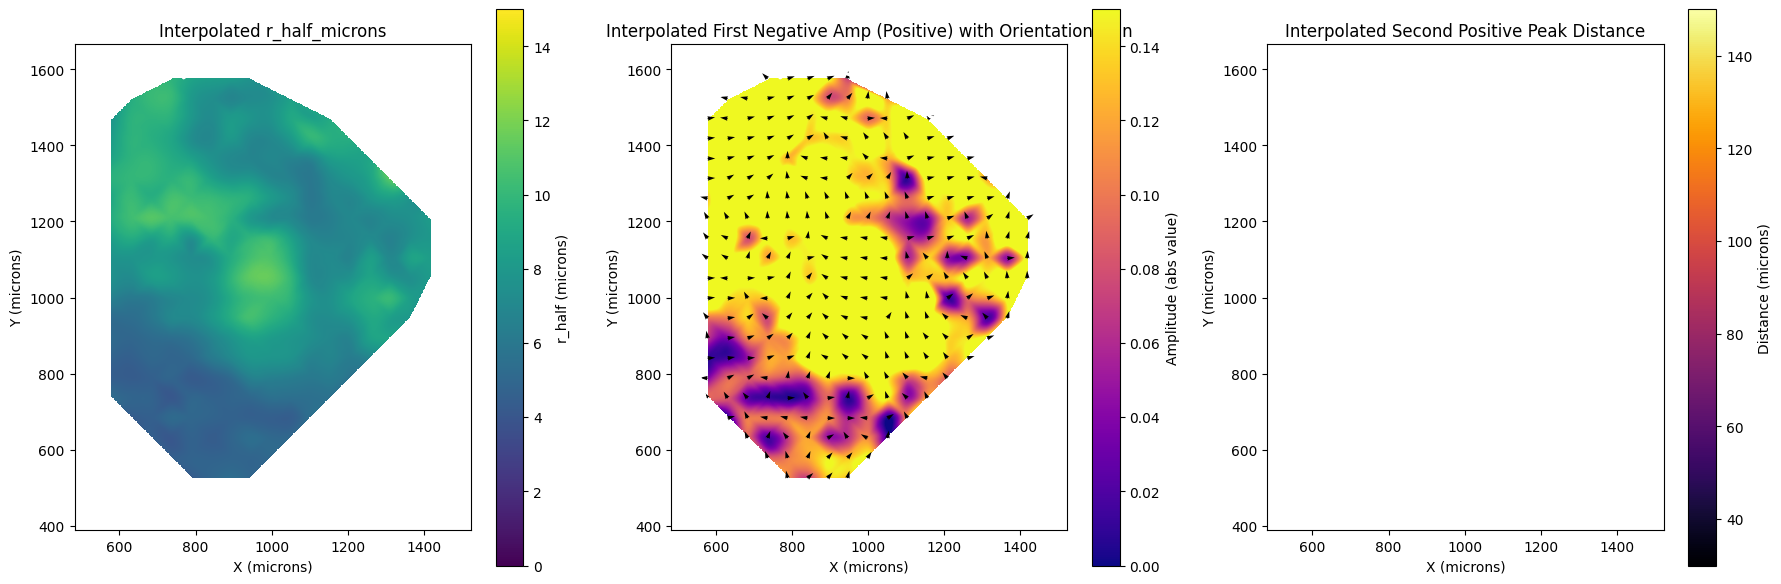

In [7]:
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import numpy as np
from scipy.interpolate import griddata

# Assume metrics_df is your DataFrame containing:
#   'x', 'y', 'r_half_microns', 'first_negative_amp', 'second_positive_distance_microns',
#   'orientation_min_degrees' (in the 0–180 range), and 'orientation_max_degrees' (if needed).
# Also assume roi_size (e.g., 330) and pixel_size (microns per pixel) are defined.

# Compute ROI center coordinates (converted to microns)
roi_center_x = (metrics_df['x'] + roi_size/2) * pixel_size
roi_center_y = (metrics_df['y'] + roi_size/2) * pixel_size

# Convert first_negative_amp to positive by multiplying by -1
first_negative_amp_positive = -metrics_df['first_negative_amp']

# Extract mask contours (convert contour coordinates to microns)
contours = find_contours(mask_binary, level=0.5)
contours_microns = [contour * pixel_size for contour in contours]

# Define grid for interpolation based on ROI centers (in microns)
xi = np.linspace(roi_center_x.min(), roi_center_x.max(), 500)
yi = np.linspace(roi_center_y.min(), roi_center_y.max(), 500)
XI, YI = np.meshgrid(xi, yi)

# Interpolate Metric 1: r_half_microns
Z1 = griddata((roi_center_x, roi_center_y), metrics_df['r_half_microns'], (XI, YI), method='cubic')
Z1_m = np.ma.masked_invalid(Z1)

# Interpolate Metric 2: first_negative_amp_positive
Z2 = griddata((roi_center_x, roi_center_y), first_negative_amp_positive, (XI, YI), method='cubic')
Z2_m = np.ma.masked_invalid(Z2)

# Interpolate Metric 3: second_positive_distance_microns
Z3 = griddata((roi_center_x, roi_center_y), metrics_df['second_positive_distance_microns'], (XI, YI), method='cubic')
Z3_m = np.ma.masked_invalid(Z3)

# Create a figure with 3 subplots (Panel 2 will have the orientation overlay)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Fixed ranges for each colormap (adjust as needed)
vmin_rhalf, vmax_rhalf = 0, 15           # for r_half_microns
vmin_neg, vmax_neg = 0, 0.15             # for first_negative_amp_positive
vmin_second, vmax_second = 30, 150       # for second_positive_distance_microns

# Panel 1: Interpolated r_half_microns
im1 = axs[0].imshow(Z1_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='viridis', vmin=vmin_rhalf, vmax=vmax_rhalf)
axs[0].set_title('Interpolated r_half_microns')
axs[0].set_xlabel('X (microns)')
axs[0].set_ylabel('Y (microns)')
axs[0].set_aspect('equal', adjustable='box')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label("r_half (microns)")
for contour in contours_microns:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')

# Panel 2: Interpolated first_negative_amp_positive with orientation_min overlay
im2 = axs[1].imshow(Z2_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='plasma', vmin=vmin_neg, vmax=vmax_neg)
axs[1].set_title('Interpolated First Negative Amp (Positive) with Orientation_min')
axs[1].set_xlabel('X (microns)')
axs[1].set_ylabel('Y (microns)')
axs[1].set_aspect('equal', adjustable='box')
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label("Amplitude (abs value)")
for contour in contours_microns:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
    
# Overlay orientation_min arrows as tilted lines on Panel 2:
# Convert orientation_min_degrees (already in [0, 180]) to radians.
angles_rad = np.deg2rad(metrics_df['orientation_min_degrees'])
# Define fixed arrow length (in microns)
arrow_length = 20  
# Compute arrow endpoints
u = arrow_length * np.cos(angles_rad)
v = arrow_length * np.sin(angles_rad)
# Overlay arrows using quiver (color blue)
axs[1].quiver(roi_center_x, roi_center_y, u, v, color='black', scale_units='xy', scale=1, width=0.005)

# Panel 3: Interpolated second_positive_distance_microns
im3 = axs[2].imshow(Z3_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='inferno', vmin=vmin_second, vmax=vmax_second)
axs[2].set_title('Interpolated Second Positive Peak Distance')
axs[2].set_xlabel('X (microns)')
axs[2].set_ylabel('Y (microns)')
axs[2].set_aspect('equal', adjustable='box')
cbar3 = fig.colorbar(im3, ax=axs[2])
cbar3.set_label("Distance (microns)")
for contour in contours_microns:
    axs[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')

plt.tight_layout()
plt.show()


Pixel size: 0.640221 micron/pixel
Found 266 candidate ROIs within the mask.
        x     y  r_half_pixels  r_half_microns  first_negative_amp  \
0    1066   656       7.000000        4.481547           -0.109771   
1    1148   656       8.000000        5.121768           -0.107668   
2    1230   656       9.000000        5.761989           -0.136187   
3    1312   656       7.968872        5.101839           -0.130520   
4     984   738       8.000000        5.121768           -0.091498   
..    ...   ...            ...             ...                 ...   
261   984  2296      16.000000       10.243536           -0.204427   
262  1066  2296      14.000000        8.963094           -0.230961   
263  1148  2296      14.000000        8.963094           -0.204895   
264  1230  2296      13.000000        8.322873           -0.164797   
265  1312  2296      12.000000        7.682652           -0.167323   

     second_positive_distance_pixels  second_positive_distance_microns  \
0        

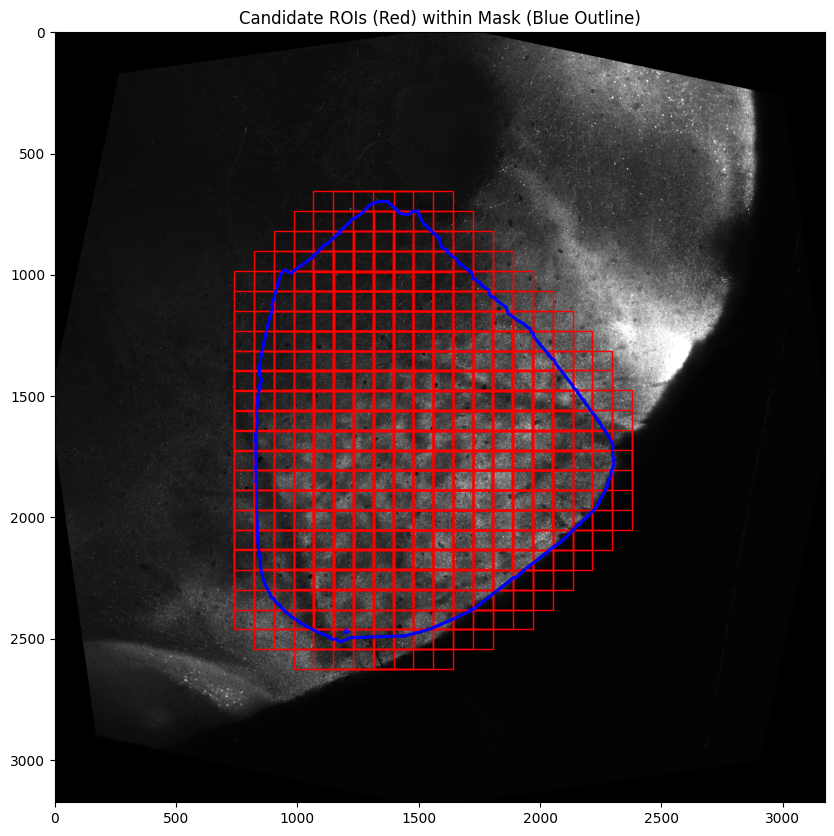

CPU times: user 8.43 s, sys: 18.9 s, total: 27.3 s
Wall time: 29.1 s


In [1]:
%%time
## parallel processingでpower最大のorientationのprofileを各tileにつき求める
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage import img_as_float, measure
from skimage.measure import find_contours, profile_line
from scipy.ndimage import gaussian_filter, map_coordinates
from numpy.fft import fft2, ifft2, fftshift
import pandas as pd
import multiprocessing as mp

# GPU imports for background subtraction acceleration
import cupy as cp
import cupyx.scipy.ndimage as cndimage

#########################################
# Functions for Autocorrelation Analysis
#########################################

def next_power_of_two(n):
    return 2**int(np.ceil(np.log2(n)))

def bandpass_filter(image, sigma_small=3, sigma_large=40):
    g_small = gaussian_filter(image, sigma=sigma_small)
    g_large = gaussian_filter(image, sigma=sigma_large)
    return g_small - g_large

def pad_image_with_mean(image, pad_size):
    h, w = image.shape
    padded = np.full((pad_size, pad_size), np.mean(image), dtype=image.dtype)
    offset_y = (pad_size - h) // 2
    offset_x = (pad_size - w) // 2
    padded[offset_y:offset_y+h, offset_x:offset_x+w] = image
    return padded, offset_x, offset_y

def compute_autocorrelation(image):
    F = fft2(image)
    auto_corr = ifft2(np.abs(F)**2).real
    return fftshift(auto_corr)

def background_subtract_gpu(image, selem_radius=50):
    image_gpu = cp.asarray(image)
    y, x = cp.ogrid[-selem_radius:selem_radius+1, -selem_radius:selem_radius+1]
    selem = (x**2 + y**2) <= selem_radius**2
    selem = selem.astype(cp.bool_)
    result_gpu = cndimage.white_tophat(image_gpu, footprint=selem)
    return cp.asnumpy(result_gpu)

def autocorrelation_radial_profile(image, do_bandpass=True, sigma_small=3, sigma_large=40,
                                   pad_factor=1.3, debug=False, subtract_background=False,
                                   rolling_radius=50):
    """
    Process a 2D grayscale image:
      - Optionally subtract background (GPU white tophat)
      - Optionally apply bandpass filter
      - Pad to a power-of-2 size and compute autocorrelation via FFT
      - Subtract the mean contribution and correct using a reference mask
      - Normalize so that the center equals 1
    Returns the corrected autocorrelation map.
    """
    if subtract_background:
        image = background_subtract_gpu(image, selem_radius=rolling_radius)
    if do_bandpass:
        image_filtered = bandpass_filter(image, sigma_small, sigma_large)
    else:
        image_filtered = image.copy()
    
    image_mean = np.mean(image_filtered)
    h, w = image_filtered.shape
    n_pixels = h * w

    target_size = int(np.ceil(pad_factor * max(w, h)))
    new_size = next_power_of_two(target_size)
    padded_image, _, _ = pad_image_with_mean(image_filtered, new_size)
    
    auto_corr = compute_autocorrelation(padded_image)
    auto_corr -= n_pixels * (image_mean**2)
    
    mask = np.ones((h, w), dtype=float)
    padded_mask, _, _ = pad_image_with_mean(mask, new_size)
    ref_corr = compute_autocorrelation(padded_mask)
    ref_corr[ref_corr == 0] = 1.0
    auto_corr_corrected = auto_corr / ref_corr
    
    center = new_size // 2
    norm_value = auto_corr_corrected[center, center]
    if norm_value != 0:
        auto_corr_corrected /= norm_value
    else:
        print("Warning: norm_value is zero; skipping normalization.")
    
    if debug:
        plt.figure(); plt.imshow(auto_corr_corrected, cmap='viridis'); plt.title("Normalized Autocorrelation"); plt.colorbar(); plt.show()
    
    return auto_corr_corrected

##############################################
# Global variables for multiprocessing workers
##############################################
global_rsc_img = None
global_pixel_size = None
roi_size = 330

def process_tile(tile_coords):
    x, y = tile_coords
    roi = global_rsc_img[y:y+roi_size, x:x+roi_size]
    # Compute the corrected autocorrelation map for this ROI.
    auto_corr_map = autocorrelation_radial_profile(
        roi, do_bandpass=True, sigma_small=3, sigma_large=40,
        pad_factor=1.3, debug=False, subtract_background=True, rolling_radius=50)
    
    new_size_map = auto_corr_map.shape[0]  # assume square
    center_pt = np.array([new_size_map // 2, new_size_map // 2])
    
    # --- Compute orientation toward the most negative point (orientation_min) ---
    Y, X = np.indices(auto_corr_map.shape)
    r_map = np.sqrt((X - center_pt[1])**2 + (Y - center_pt[0])**2)
    # Define outer limit in pixels (100 microns converted to pixels)
    outer_limit_pixels = 100 / global_pixel_size
    # Exclude pixels with radius less than 5 pixels or greater than outer_limit_pixels.
    exclusion_mask = (r_map > 5) & (r_map <= outer_limit_pixels)
    neg_indices = np.where(auto_corr_map[exclusion_mask] < 0)[0]
    if neg_indices.size > 0:
        # Get the corresponding indices (in the flattened array) and then convert back to 2D coordinates.
        flat_neg = auto_corr_map[exclusion_mask]
        # Find the index where the value is minimum.
        flat_idx = np.argmin(flat_neg)
        # Now recover the 2D index from the mask.
        all_coords = np.argwhere(exclusion_mask)
        min_coord = all_coords[flat_idx]
    else:
        min_coord = center_pt
    # Compute orientation from center to the most negative point.
    orientation_min = np.arctan2(min_coord[0] - center_pt[0], min_coord[1] - center_pt[1])
    orientation_min_degrees = np.degrees(orientation_min) % 180

    # --- Extract 1D profile along the line in direction orientation_min ---
    # Define maximum line length as half the size of the autocorrelation map.
    L = new_size_map / 2.0
    # Compute endpoint along the line (profile_line expects (row, col) order).
    end_pt = (center_pt[0] + L * np.sin(orientation_min),
              center_pt[1] + L * np.cos(orientation_min))
    profile_line_vals = profile_line(auto_corr_map, (center_pt[0], center_pt[1]), end_pt,
                                     order=1, mode='reflect')
    profile_line_vals = np.array(profile_line_vals)
    num_points = len(profile_line_vals)
    distances_line = np.linspace(0, L, num_points)
    
    # --- Measurement 1: 50% width along the profile line ---
    # Use np.interp to find the distance at which the profile equals 0.5.
    if np.any(profile_line_vals < 0.5):
        # Find first index where profile_line_vals < 0.5.
        idx = np.argmax(profile_line_vals < 0.5)
        r_half = np.interp(0.5, [profile_line_vals[idx-1], profile_line_vals[idx]],
                           [distances_line[idx-1], distances_line[idx]])
    else:
        r_half = None

    # --- Measurement 2: Amplitude of the first negative peak ---
    # Find indices where profile_line_vals is negative.
    neg_indices_line = np.where(profile_line_vals < 0)[0]
    if neg_indices_line.size > 0:
        # In the first contiguous block of negative values, select the index with minimum value.
        diff = np.diff(neg_indices_line)
        breaks = np.where(diff != 1)[0]
        if breaks.size > 0:
            first_segment = neg_indices_line[:breaks[0]+1]
        else:
            first_segment = neg_indices_line
        idx_neg = first_segment[np.argmin(profile_line_vals[first_segment])]
        first_negative_amp = profile_line_vals[idx_neg]
        first_negative_index = idx_neg
    else:
        first_negative_amp = None
        first_negative_index = None

    # --- Measurement 3: Distance to the second positive peak ---
    # Compute the derivative of the 1D profile.
    d_profile = np.diff(profile_line_vals)
    # Smooth the derivative using Savitzky–Golay filter for robust zero crossing detection.
    from scipy.signal import savgol_filter
    window_length = 11  # must be odd
    polyorder = 3
    d_profile_sg = savgol_filter(d_profile, window_length, polyorder)
    # Compute the midpoints of the radii for plotting the derivative.
    r_mid = (profile_line_vals[:-1] + profile_line_vals[1:]) / 2.0
    
    if first_negative_index is not None:
        # Consider derivative indices after the first negative peak.
        candidate_indices = np.where(np.isclose(d_profile_sg[first_negative_index+1:], 0, atol=1e-6))[0]
        if candidate_indices.size > 0:
            second_positive_index = first_negative_index + 1 + candidate_indices[0]
        else:
            # Fallback: find first index where derivative becomes <= 0.
            candidate_indices = np.where(d_profile_sg[first_negative_index+1:] <= 0)[0]
            if candidate_indices.size > 0:
                second_positive_index = first_negative_index + 1 + candidate_indices[0]
            else:
                second_positive_index = None
    else:
        second_positive_index = None

    if second_positive_index is not None:
        second_positive_distance = distances_line[second_positive_index]
    else:
        second_positive_distance = None
        # Plot the original and smoothed derivative.
        plt.figure(figsize=(8, 6))
        plt.plot(r_mid, d_profile, label='Original Derivative', alpha=0.5)
        plt.plot(r_mid, d_profile_sg, label='Savitzky-Golay Smoothing', linewidth=2)
        plt.xlabel("Radius (pixels)")
        plt.ylabel("Derivative")
        plt.title("Smoothed Derivative of Radial Profile")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'x': x,
        'y': y,
        'r_half_pixels': r_half,
        'r_half_microns': r_half * global_pixel_size if r_half is not None else None,
        'first_negative_amp': first_negative_amp,
        'second_positive_distance_pixels': second_positive_distance,
        'second_positive_distance_microns': second_positive_distance * global_pixel_size if second_positive_distance is not None else None,
        'orientation_min_radians': orientation_min,
        'orientation_min_degrees': orientation_min_degrees,
        'profile_line': profile_line_vals,
        'distances_line_pixels': distances_line
    }


#######################################
# Main code: Tiling and Metrics Extraction
#######################################
if __name__ == "__main__":
    # File paths
    rsc_path = 'RSC_118.tif'
    mask_path = 'Mask_118.tif'
    
    # Read main image and mask; convert to float.
    rsc_img = tifffile.imread(rsc_path)
    mask_img = tifffile.imread(mask_path)
    rsc_img = img_as_float(rsc_img)
    mask_img = img_as_float(mask_img)
    
    # Extract pixel size from main image metadata (using XResolution)
    with tifffile.TiffFile(rsc_path) as tif:
        page = tif.pages[0]
        x_res_fraction = page.tags['XResolution'].value
        pixel_size = x_res_fraction[0] / x_res_fraction[1]
        print("Pixel size:", pixel_size, "micron/pixel")
    
    # Set globals for worker processes.
    global_rsc_img = rsc_img
    global_pixel_size = pixel_size
    
    # Create a binary mask from mask image.
    mask_binary = mask_img > 0.5
    
    # Tiling parameters
    stride = 82  # slide window by 10 pixels
    coverage_threshold = 0.5  # require at least 90% mask coverage in ROI
    
    # Collect candidate tile positions
    tile_positions = []
    for y in range(0, rsc_img.shape[0] - roi_size + 1, stride):
        for x in range(0, rsc_img.shape[1] - roi_size + 1, stride):
            roi_mask = mask_binary[y:y+roi_size, x:x+roi_size]
            if roi_mask.mean() >= coverage_threshold:
                tile_positions.append((x, y))
    
    print(f"Found {len(tile_positions)} candidate ROIs within the mask.")
    
    # Use multiprocessing.Pool to process candidate ROIs in parallel.
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(process_tile, tile_positions)
    
    metrics_df = pd.DataFrame(results)
    print(metrics_df)
    
    # Visualization: draw candidate ROI rectangles and overlay mask outline.
    import matplotlib.patches as patches
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(rsc_img, cmap='gray')
    for (x, y) in tile_positions:
        rect = patches.Rectangle((x, y), roi_size, roi_size, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
    contours = find_contours(mask_binary, level=0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
    ax.set_title("Candidate ROIs (Red) within Mask (Blue Outline)")
    plt.show()
    
    # Save or further process metrics_df as needed.


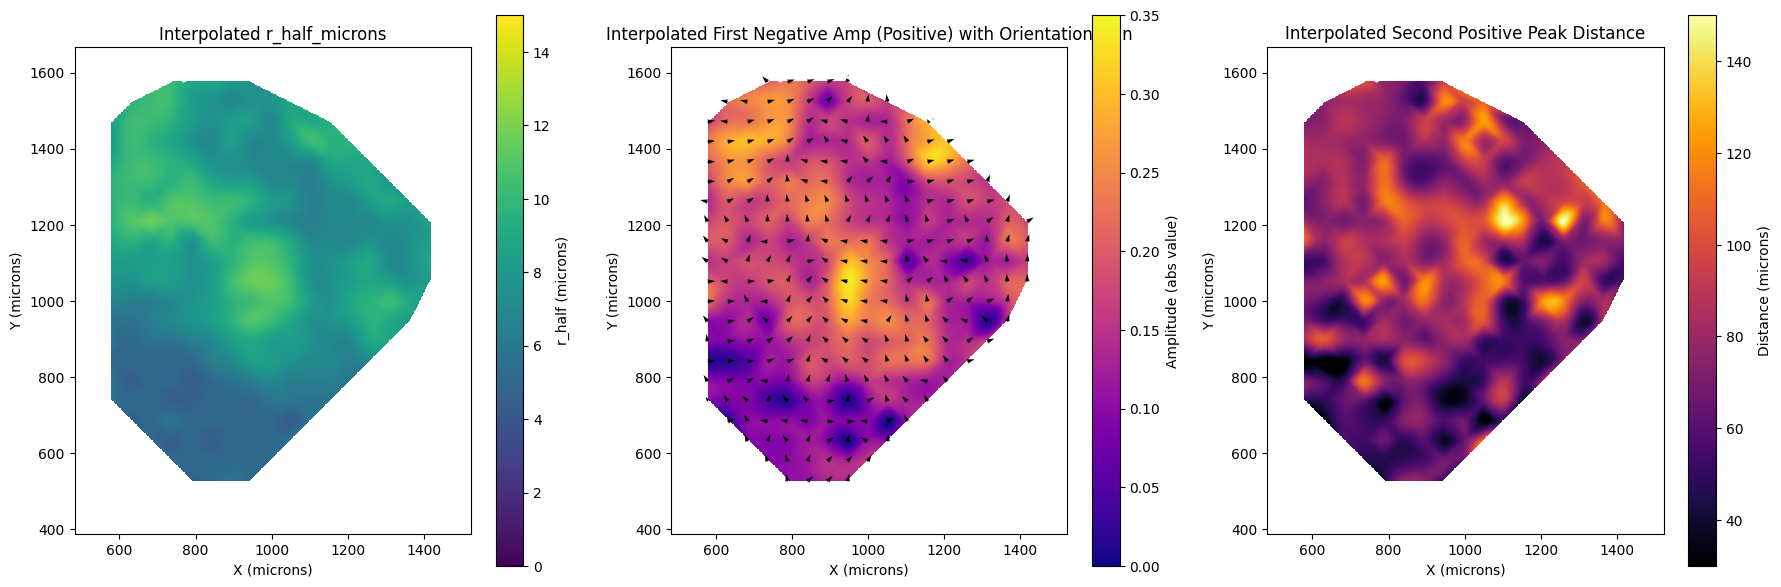

In [3]:
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import numpy as np
from scipy.interpolate import griddata

# Assume metrics_df is your DataFrame containing:
#   'x', 'y', 'r_half_microns', 'first_negative_amp', 'second_positive_distance_microns',
#   'orientation_min_degrees' (in the 0–180 range), and 'orientation_max_degrees' (if needed).
# Also assume roi_size (e.g., 330) and pixel_size (microns per pixel) are defined.

# Compute ROI center coordinates (converted to microns)
roi_center_x = (metrics_df['x'] + roi_size/2) * pixel_size
roi_center_y = (metrics_df['y'] + roi_size/2) * pixel_size

# Convert first_negative_amp to positive by multiplying by -1
first_negative_amp_positive = -metrics_df['first_negative_amp']

# Extract mask contours (convert contour coordinates to microns)
contours = find_contours(mask_binary, level=0.5)
contours_microns = [contour * pixel_size for contour in contours]

# Define grid for interpolation based on ROI centers (in microns)
xi = np.linspace(roi_center_x.min(), roi_center_x.max(), 500)
yi = np.linspace(roi_center_y.min(), roi_center_y.max(), 500)
XI, YI = np.meshgrid(xi, yi)

# Interpolate Metric 1: r_half_microns
Z1 = griddata((roi_center_x, roi_center_y), metrics_df['r_half_microns'], (XI, YI), method='cubic')
Z1_m = np.ma.masked_invalid(Z1)

# Interpolate Metric 2: first_negative_amp_positive
Z2 = griddata((roi_center_x, roi_center_y), first_negative_amp_positive, (XI, YI), method='cubic')
Z2_m = np.ma.masked_invalid(Z2)

# Interpolate Metric 3: second_positive_distance_microns
Z3 = griddata((roi_center_x, roi_center_y), metrics_df['second_positive_distance_microns'], (XI, YI), method='cubic')
Z3_m = np.ma.masked_invalid(Z3)

# Create a figure with 3 subplots (Panel 2 will have the orientation overlay)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Fixed ranges for each colormap (adjust as needed)
vmin_rhalf, vmax_rhalf = 0, 15           # for r_half_microns
vmin_neg, vmax_neg = 0, 0.35             # for first_negative_amp_positive
vmin_second, vmax_second = 30, 150       # for second_positive_distance_microns

# Panel 1: Interpolated r_half_microns
im1 = axs[0].imshow(Z1_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='viridis', vmin=vmin_rhalf, vmax=vmax_rhalf)
axs[0].set_title('Interpolated r_half_microns')
axs[0].set_xlabel('X (microns)')
axs[0].set_ylabel('Y (microns)')
axs[0].set_aspect('equal', adjustable='box')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label("r_half (microns)")
for contour in contours_microns:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')

# Panel 2: Interpolated first_negative_amp_positive with orientation_min overlay
im2 = axs[1].imshow(Z2_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='plasma', vmin=vmin_neg, vmax=vmax_neg)
axs[1].set_title('Interpolated First Negative Amp (Positive) with Orientation_min')
axs[1].set_xlabel('X (microns)')
axs[1].set_ylabel('Y (microns)')
axs[1].set_aspect('equal', adjustable='box')
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label("Amplitude (abs value)")
for contour in contours_microns:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
    
# Overlay orientation_min arrows as tilted lines on Panel 2:
# Convert orientation_min_degrees (already in [0, 180]) to radians.
angles_rad = np.deg2rad(metrics_df['orientation_min_degrees'])
# Define fixed arrow length (in microns)
arrow_length = 20  
# Compute arrow endpoints
u = arrow_length * np.cos(angles_rad)
v = arrow_length * np.sin(angles_rad)
# Overlay arrows using quiver (color blue)
axs[1].quiver(roi_center_x, roi_center_y, u, v, color='black', scale_units='xy', scale=1, width=0.005)

# Panel 3: Interpolated second_positive_distance_microns
im3 = axs[2].imshow(Z3_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='inferno', vmin=vmin_second, vmax=vmax_second)
axs[2].set_title('Interpolated Second Positive Peak Distance')
axs[2].set_xlabel('X (microns)')
axs[2].set_ylabel('Y (microns)')
axs[2].set_aspect('equal', adjustable='box')
cbar3 = fig.colorbar(im3, ax=axs[2])
cbar3.set_label("Distance (microns)")
for contour in contours_microns:
    axs[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')

plt.tight_layout()
plt.show()


Found 1 tiles with NaN for second_positive_distance_microns.
Plotting 1D profile and derivative for tile at (1968, 1558):


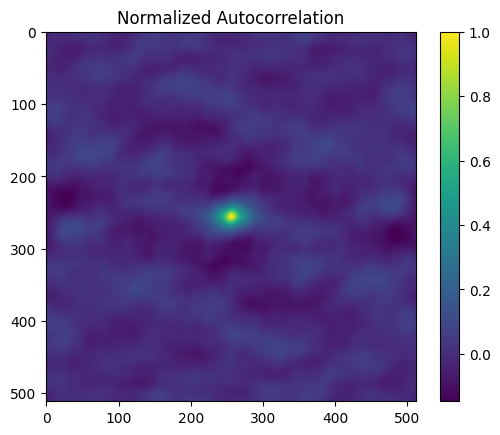

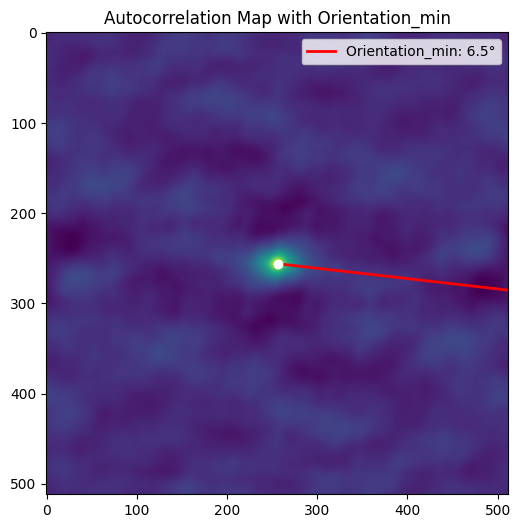

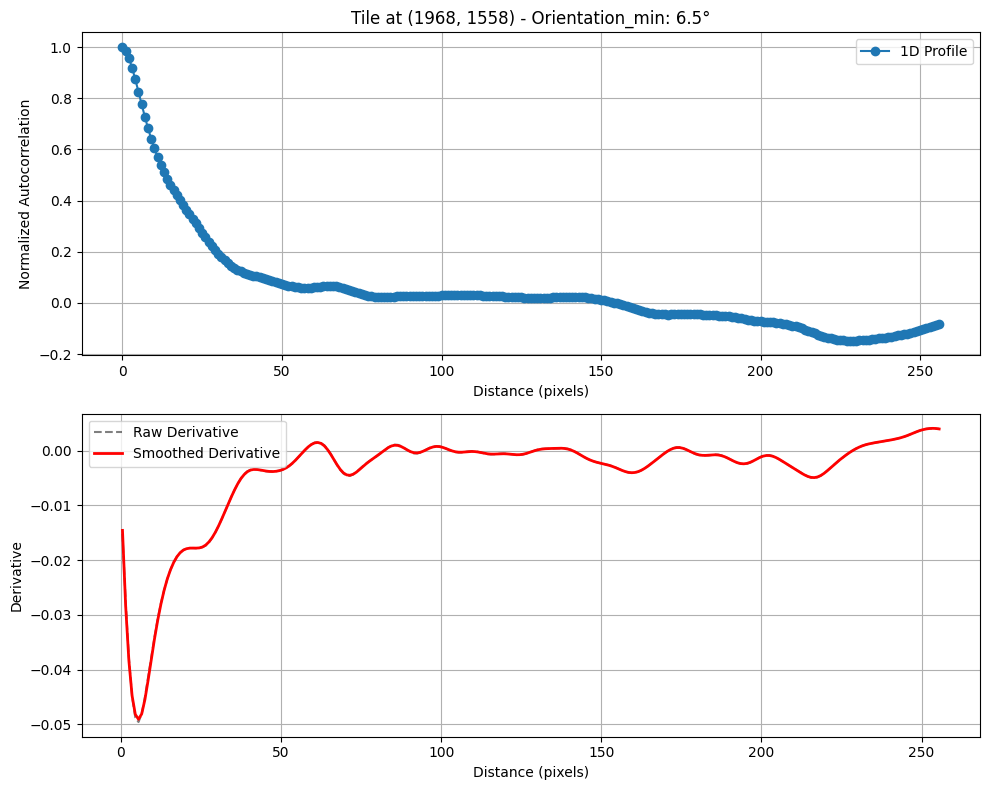

In [10]:
# Define a debug version of process_tile that plots the 1D profile and derivative.
def process_tile_debug(tile_coords):
    x, y = tile_coords
    roi = global_rsc_img[y:y+roi_size, x:x+roi_size]
    # Compute the corrected autocorrelation map for this ROI.
    auto_corr_map = autocorrelation_radial_profile(
        roi, do_bandpass=True, sigma_small=3, sigma_large=40,
        pad_factor=1.3, debug=True, subtract_background=True, rolling_radius=50)
    
    new_size_map = auto_corr_map.shape[0]  # assume square
    center_pt = np.array([new_size_map // 2, new_size_map // 2])
    
    # --- Compute orientation toward the most negative point (orientation_min) ---
    Y, X = np.indices(auto_corr_map.shape)
    r_map = np.sqrt((X - center_pt[1])**2 + (Y - center_pt[0])**2)
    exclusion_mask = r_map > 5  # exclude a small central region
    neg_vals = auto_corr_map[exclusion_mask]
    min_val = np.min(neg_vals)
    min_coords = np.argwhere((auto_corr_map == min_val) & exclusion_mask)
    if min_coords.shape[0] > 0:
        min_coord = min_coords[0]
    else:
        min_coord = center_pt
    # Compute orientation from center to min_coord.
    orientation_min = np.arctan2(min_coord[0] - center_pt[0], min_coord[1] - center_pt[1])
    orientation_min_degrees = np.degrees(orientation_min) % 180

    # --- Extract 1D profile along the line in direction orientation_min ---
    L = new_size_map / 2.0  # maximum line length
    # profile_line expects coordinates in (row, col) order.
    end_pt = (center_pt[0] + L * np.sin(orientation_min),
              center_pt[1] + L * np.cos(orientation_min))
    profile_line_vals = profile_line(auto_corr_map, (center_pt[0], center_pt[1]), end_pt,
                                     order=1, mode='reflect')
    profile_line_vals = np.array(profile_line_vals)
    num_points = len(profile_line_vals)
    distances_line = np.linspace(0, L, num_points)
    
    # --- Measurement 1: 50% width along the profile line (using np.interp) ---
    if np.any(profile_line_vals < 0.5):
        idx = np.argmax(profile_line_vals < 0.5)
        r_half = np.interp(0.5, [profile_line_vals[idx-1], profile_line_vals[idx]],
                           [distances_line[idx-1], distances_line[idx]])
    else:
        r_half = None

    # --- Measurement 2: Amplitude of the first negative peak ---
    neg_indices_line = np.where(profile_line_vals < 0)[0]
    if neg_indices_line.size > 0:
        diff = np.diff(neg_indices_line)
        breaks = np.where(diff != 1)[0]
        if breaks.size > 0:
            first_segment = neg_indices_line[:breaks[0]+1]
        else:
            first_segment = neg_indices_line
        idx_neg = first_segment[np.argmin(profile_line_vals[first_segment])]
        first_negative_amp = profile_line_vals[idx_neg]
        first_negative_index = idx_neg
    else:
        first_negative_amp = None
        first_negative_index = None

    # --- Measurement 3: Distance to the second positive peak ---
    d_profile = np.diff(profile_line_vals)
    from scipy.signal import savgol_filter
    window_length = 11  # must be odd
    polyorder = 3
    d_profile_sg = savgol_filter(d_profile, window_length, polyorder)
    
    if first_negative_index is not None:
        candidates = np.where(np.isclose(d_profile_sg[first_negative_index+1:], 0, atol=1e-6))[0]
        if candidates.size > 0:
            second_positive_index = first_negative_index + 1 + candidates[0]
        else:
            candidate_indices = np.where(d_profile_sg[first_negative_index+1:] <= 0)[0]
            if candidate_indices.size > 0:
                second_positive_index = first_negative_index + 1 + candidate_indices[0]
            else:
                second_positive_index = None
    else:
        second_positive_index = None

    if second_positive_index is not None:
        second_positive_distance = distances_line[second_positive_index]
    else:
        second_positive_distance = None

    # --- Plot the autocorrelation map with the orientation line ---
    plt.figure(figsize=(6,6))
    plt.imshow(auto_corr_map, cmap='viridis')
    # Define a fixed length for the orientation line (e.g., L)
    plt.plot([center_pt[1], center_pt[1] + L * np.cos(orientation_min)],
             [center_pt[0], center_pt[0] + L * np.sin(orientation_min)],
             'r-', linewidth=2, label=f"Orientation_min: {orientation_min_degrees:.1f}°")
    plt.scatter(center_pt[1], center_pt[0], color='white', zorder=10)
    plt.title("Autocorrelation Map with Orientation_min")
    plt.legend()
    plt.show()
    
    # --- Plot the 1D profile and its derivative ---
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.plot(distances_line, profile_line_vals, 'o-', label='1D Profile')
    plt.xlabel("Distance (pixels)")
    plt.ylabel("Normalized Autocorrelation")
    plt.title(f"Tile at ({x}, {y}) - Orientation_min: {orientation_min_degrees:.1f}°")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2,1,2)
    r_mid = (distances_line[:-1] + distances_line[1:]) / 2.0
    plt.plot(r_mid, d_profile, 'k--', alpha=0.5, label='Raw Derivative')
    plt.plot(r_mid, d_profile_sg, 'r-', linewidth=2, label='Smoothed Derivative')
    plt.xlabel("Distance (pixels)")
    plt.ylabel("Derivative")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'x': x,
        'y': y,
        'r_half_pixels': r_half,
        'r_half_microns': r_half * global_pixel_size if r_half is not None else None,
        'first_negative_amp': first_negative_amp,
        'second_positive_distance_pixels': second_positive_distance,
        'second_positive_distance_microns': second_positive_distance * global_pixel_size if second_positive_distance is not None else None,
        'orientation_min_radians': orientation_min,
        'orientation_min_degrees': orientation_min_degrees,
        'profile_line': profile_line_vals,
        'distances_line_pixels': distances_line
    }


#######################################
# Main code: Process NaN tiles with plotting (no multiprocessing)
#######################################
# Assume metrics_df is already computed.
nan_tiles = metrics_df[metrics_df['second_positive_distance_microns'].isna()]
print(f"Found {len(nan_tiles)} tiles with NaN for second_positive_distance_microns.")

# Process these tiles with plotting in the main process.
for idx, row in nan_tiles.iterrows():
    tile_coords = (row['x'], row['y'])
    print(f"Plotting 1D profile and derivative for tile at {tile_coords}:")
    process_tile_debug(tile_coords)
